In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_cor
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats


sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


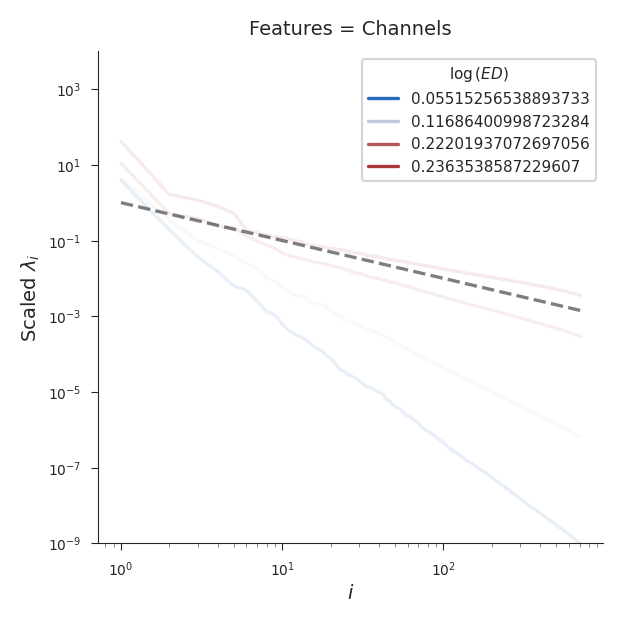

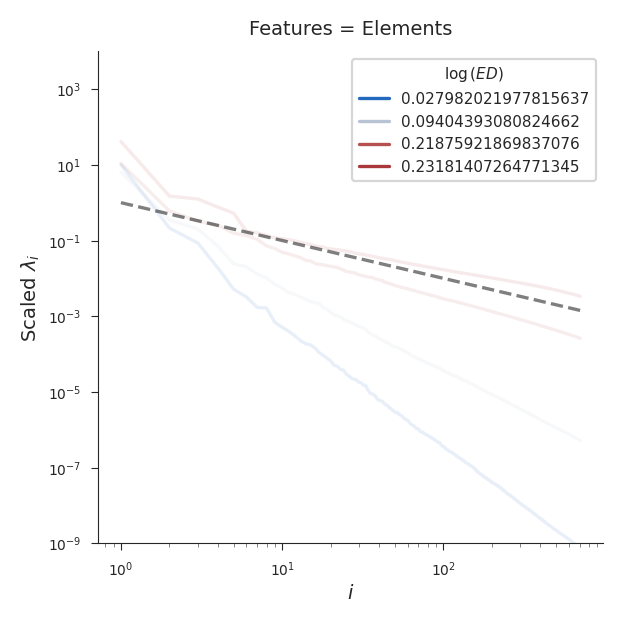

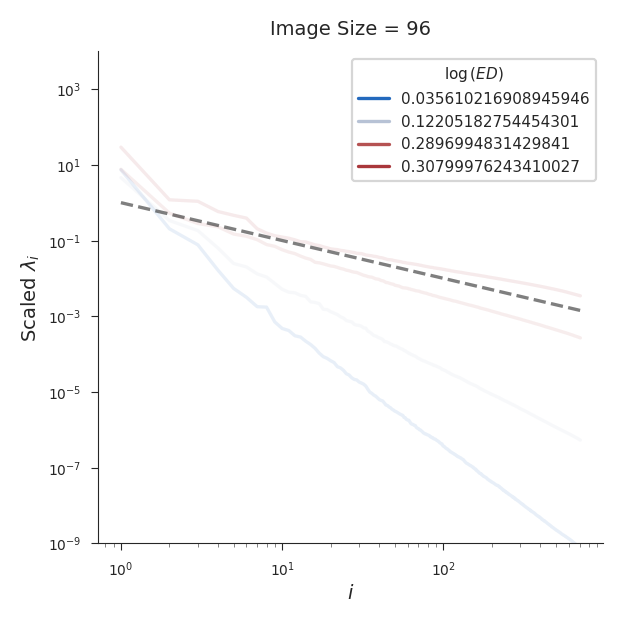

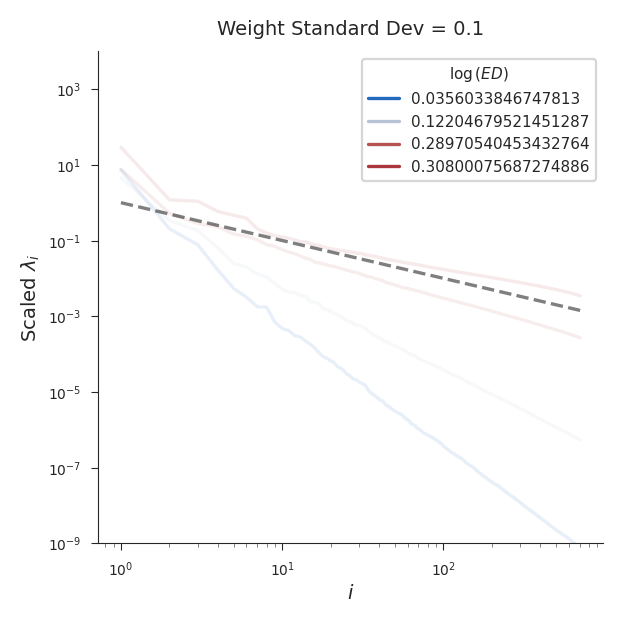

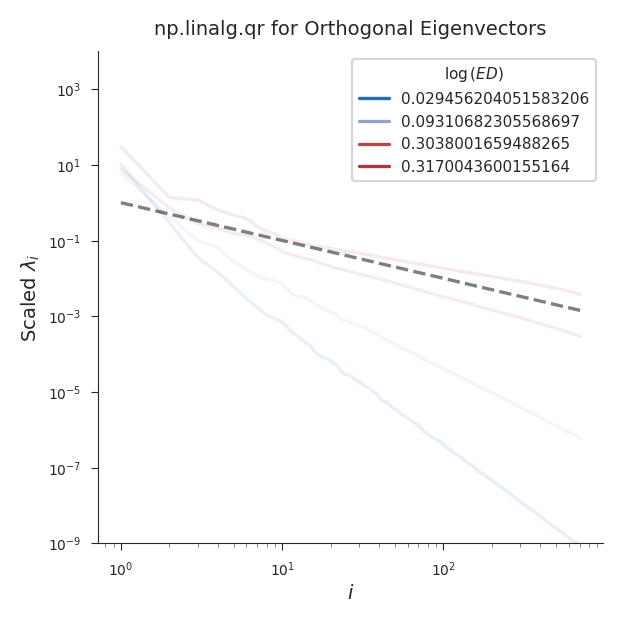

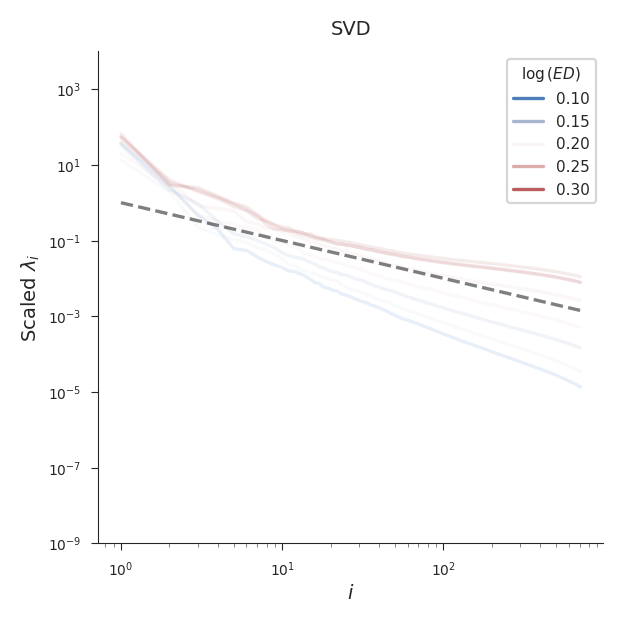

In [24]:
file = ['alpha', 'alpha_el', 'alpha-e96', 'alpha-el0.1', 'alpha-O', 'alpha-SVD']
#file = ['alpha']
#pooling = ['max', 'none']
p = 'max'
spectra = True
encoding = False

for f in file:
    if f == 'alpha':
        t = 'Features = Channels'
    elif f == 'alpha_el':
        t = 'Features = Elements'
    elif f == 'alpha-e96':
        t = 'Image Size = 96'
    elif f == 'alpha-el0.1':
        t = 'Weight Standard Dev = 0.1'
    elif f == 'alpha-O':
        t = 'np.linalg.qr for Orthogonal Eigenvectors'
    elif f == 'alpha-SVD':
        t = 'SVD'
        
    
    #eigenspectra

    if spectra:
        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                    units='id', alpha=0.1, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
        
        
    #encoding score
    
    if encoding:
        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
        data = pd.merge(de, dm, on=id_columns)
        data = data[ (data['layer']=='c2') ]
        data['id'] = data[id_columns].sum(axis='columns')

        predictors = ['effective dimensionality', 'alpha']
        for pred in predictors:
            r, p_val = sp.stats.pearsonr(data[pred], data['score'])

            fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
            sns.regplot(data=data, x=pred, y='score', 
                        logx=True,
                        scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                        line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                        ax=ax)
            ax.set(xlabel=f'{pred} (pooling: {p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
            ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
            #ax.set_ylim(bottom=0, top=0.65)
            #ax.set_xlim(0.8, 270)

plt.show()

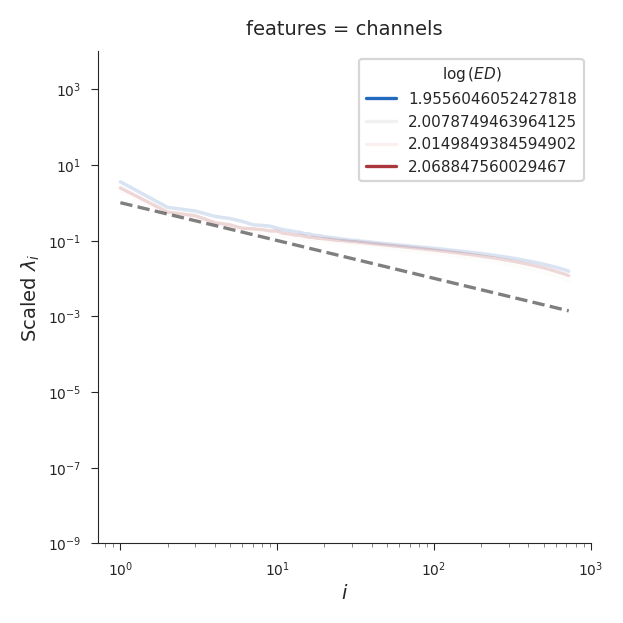

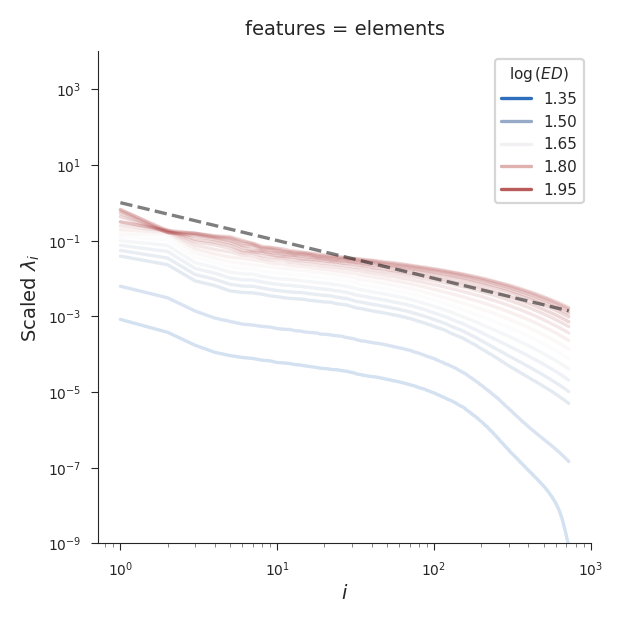

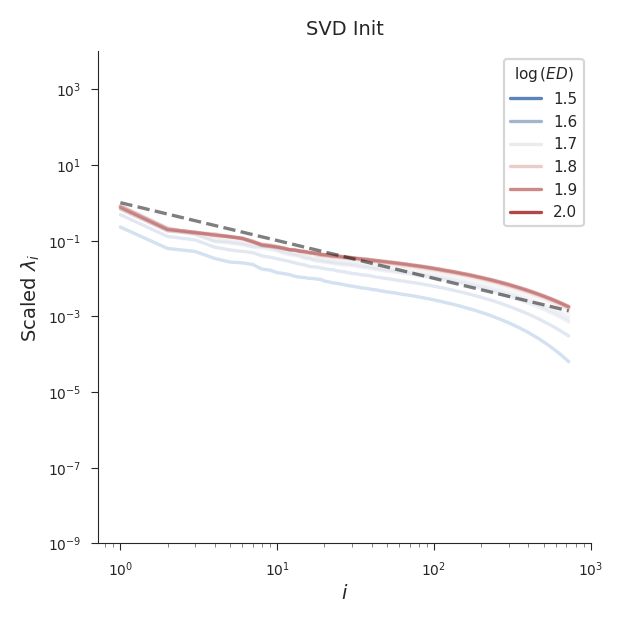

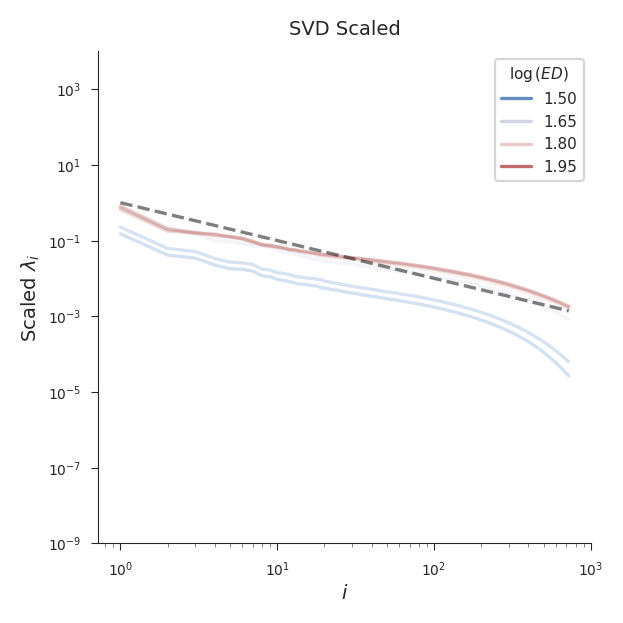

In [2]:
file = ['alpha', 'Eigall',  'SVD4', 'SVD-scaled2']
#, 'alpha-O', 'SVDall', 'SVD2', 'SVD3', 'Eig2'
#file = ['alpha']


for f in file:
    p = 'none'
    spectra = True
    encoding = False
    
    if f == 'alpha':
        t = 'features = channels'
    if f == 'alpha-O':
        t = 'elements x channels'
    elif f == 'Eigall':
        t = 'features = elements'
    elif f == 'SVDall':
        t = 'SVD init'
    elif f == 'SVD2':
        t = 'SVD2'
        p = 'none'
        encoding = False
    elif f == 'SVD3':
        t = 'SVD3'
        p = 'none'
        encoding = False
    elif f == 'SVD4':
        t = 'SVD Init'
    elif f == 'Eig2':
        t = 'channels2'
    elif f == 'SVD-scaled2':
        t = 'SVD Scaled'
        
    
    #eigenspectra

    if spectra:
        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
        
        
    #encoding score
    
    if encoding:
        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
        data = pd.merge(de, dm, on=id_columns)
        data = data[ (data['layer']=='c2') ]
        data['id'] = data[id_columns].sum(axis='columns')

        predictors = ['effective dimensionality', 'alpha']
        for pred in predictors:
            r, p_val = sp.stats.pearsonr(data[pred], data['score'])

            fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
            sns.regplot(data=data, x=pred, y='score', 
                        logx=True,
                        scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                        line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                        ax=ax)
            ax.set(xlabel=f'{pred} (pooling: {p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
            ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
            #ax.set_ylim(bottom=0, top=0.65)
            #ax.set_xlim(0.8, 270)

plt.show()

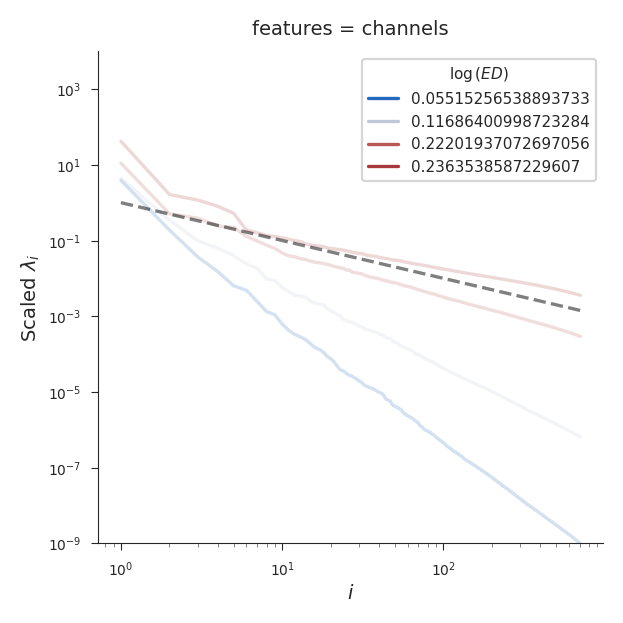

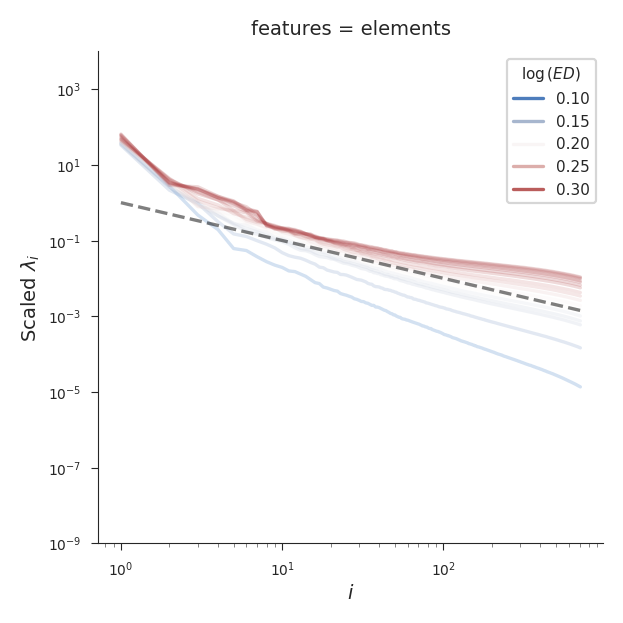

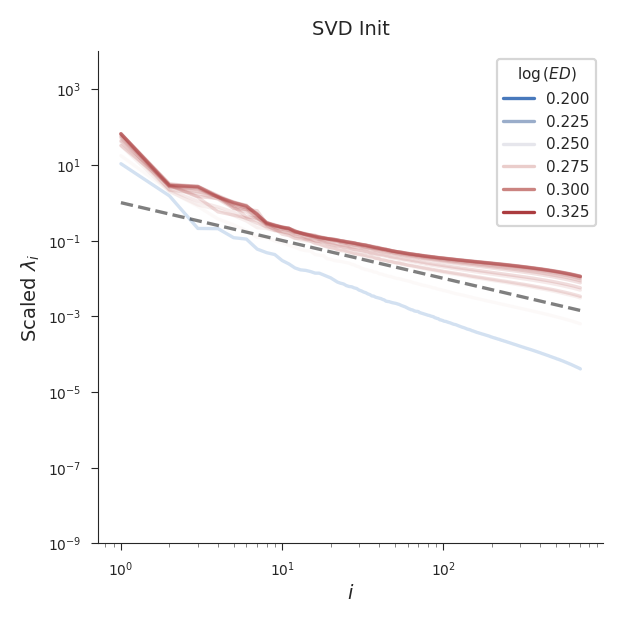

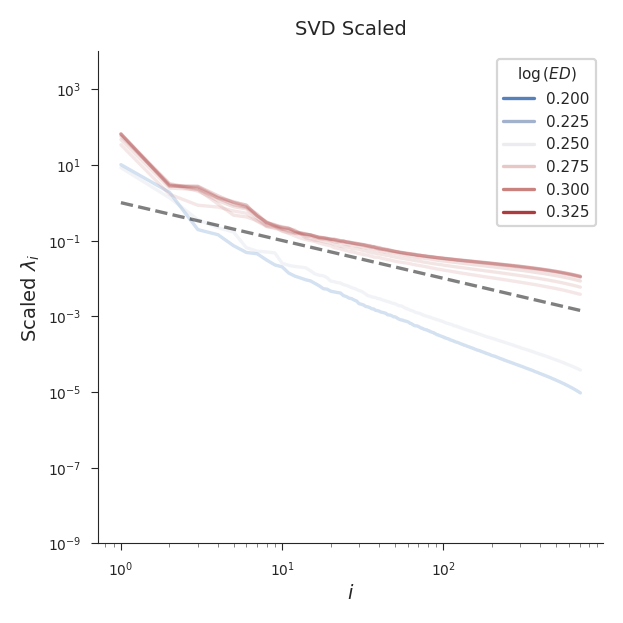

In [4]:
file = ['alpha', 'Eigall',  'SVD4', 'SVD-scaled2']
#, 'alpha-O', 'SVDall', 'SVD2', 'SVD3', 'Eig2'
#file = ['alpha']

for f in file:
    p = 'max'
    spectra = True
    encoding = False
    
    if f == 'alpha':
        t = 'features = channels'
    if f == 'alpha-O':
        t = 'elements x channels'
    elif f == 'Eigall':
        t = 'features = elements'
    elif f == 'SVDall':
        t = 'SVD init'
    elif f == 'SVD2':
        t = 'SVD2'
        p = 'none'
        encoding = False
    elif f == 'SVD3':
        t = 'SVD3'
        p = 'none'
        encoding = False
    elif f == 'SVD4':
        t = 'SVD Init'
    elif f == 'Eig2':
        t = 'channels2'
    elif f == 'SVD-scaled2':
        t = 'SVD Scaled'
        
    
    #eigenspectra

    if spectra:
        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
        
        
    #encoding score
    
    if encoding:
        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
        data = pd.merge(de, dm, on=id_columns)
        data = data[ (data['layer']=='c2') ]
        data['id'] = data[id_columns].sum(axis='columns')

        predictors = ['effective dimensionality', 'alpha']
        for pred in predictors:
            r, p_val = sp.stats.pearsonr(data[pred], data['score'])

            fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
            sns.regplot(data=data, x=pred, y='score', 
                        logx=True,
                        scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                        line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                        ax=ax)
            ax.set(xlabel=f'{pred} (pooling: {p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
            ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
            #ax.set_ylim(bottom=0, top=0.65)
            #ax.set_xlim(0.8, 270)

plt.show()

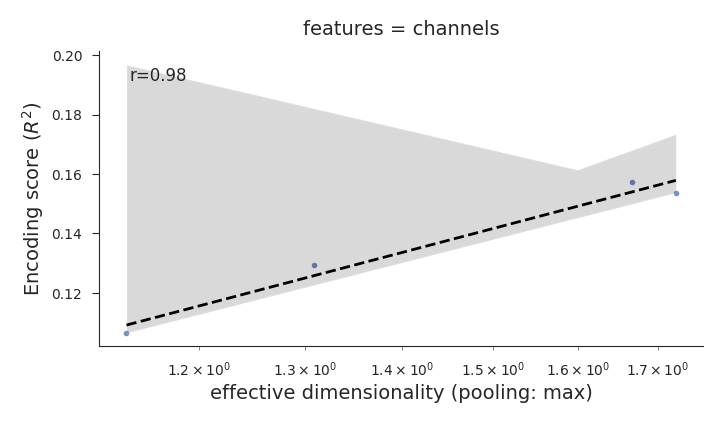

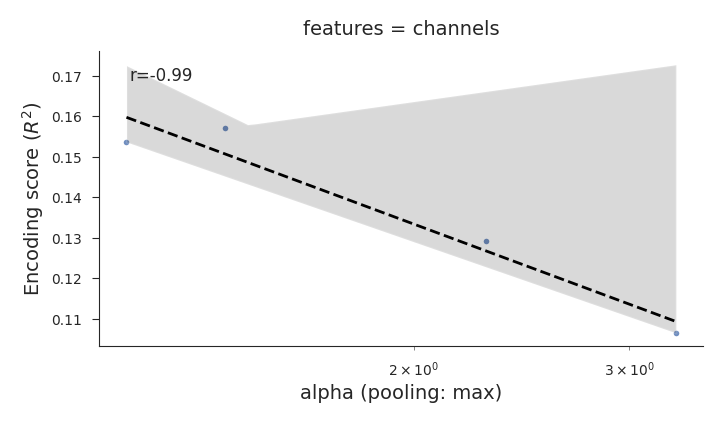

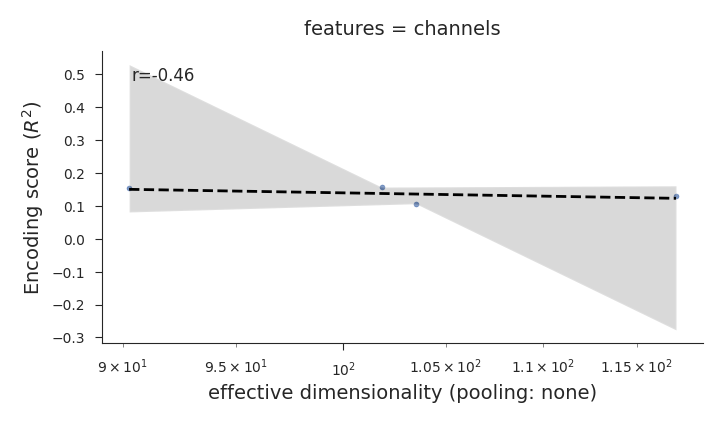

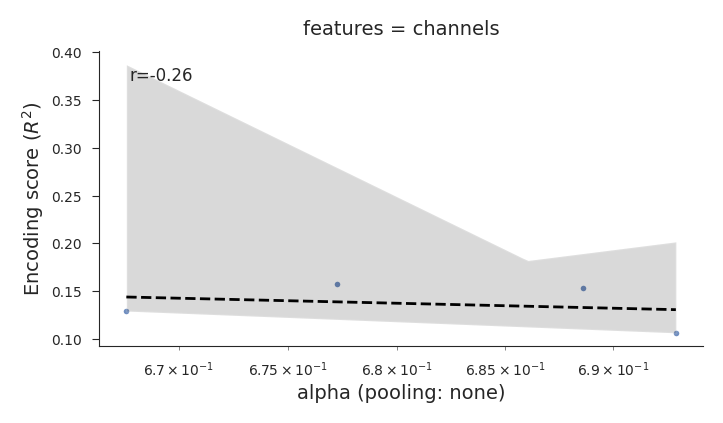

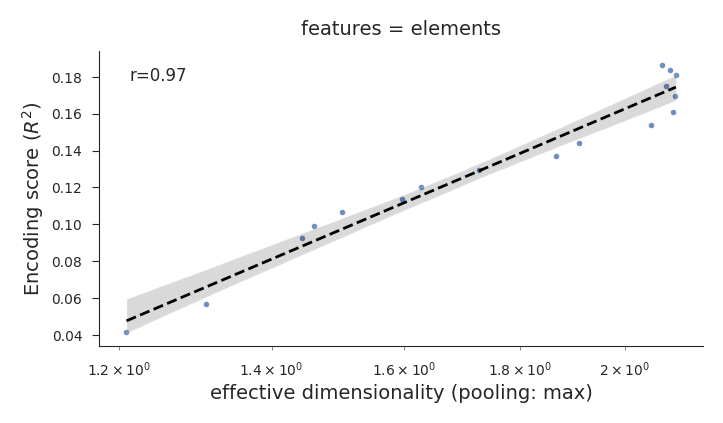

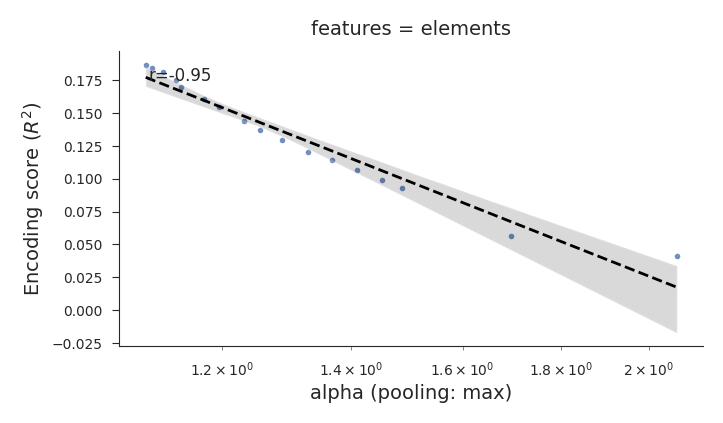

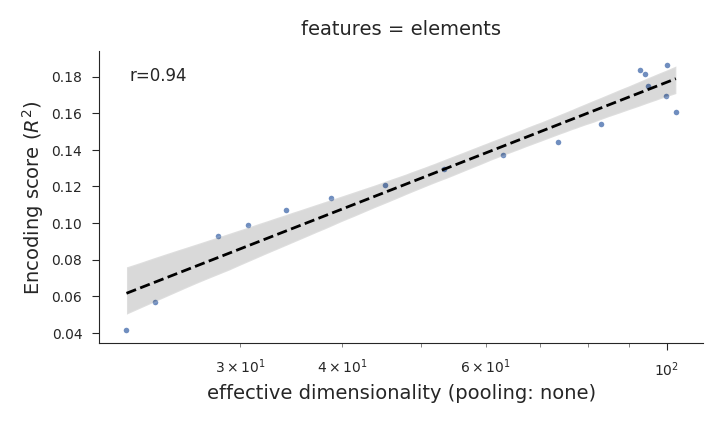

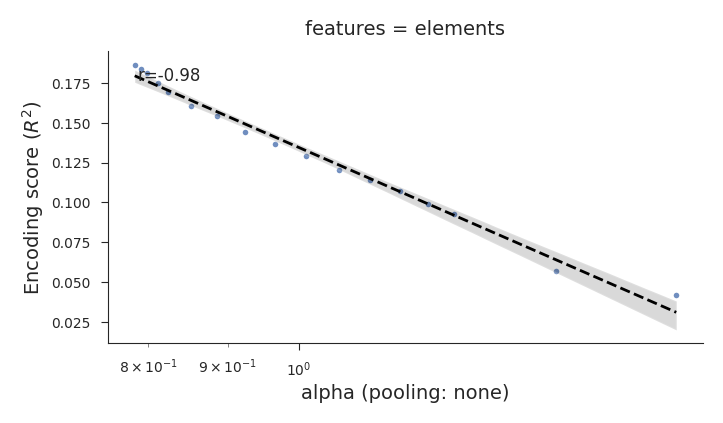

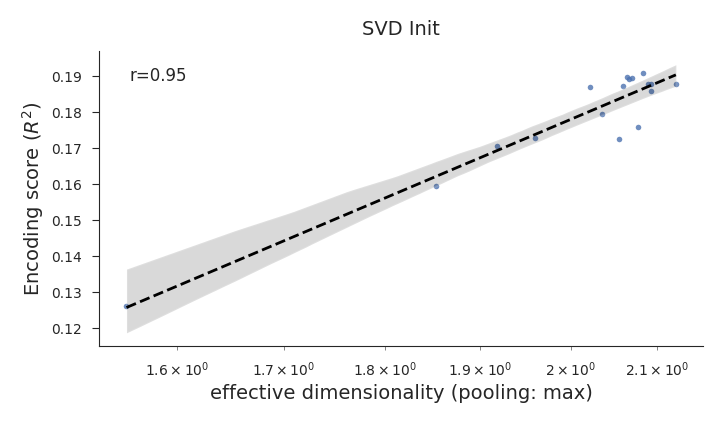

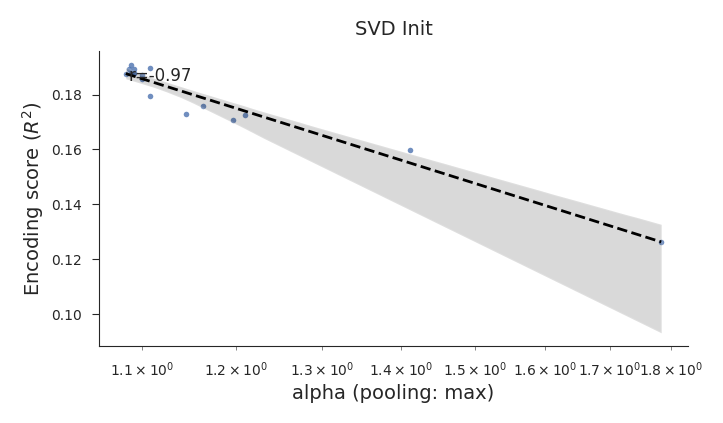

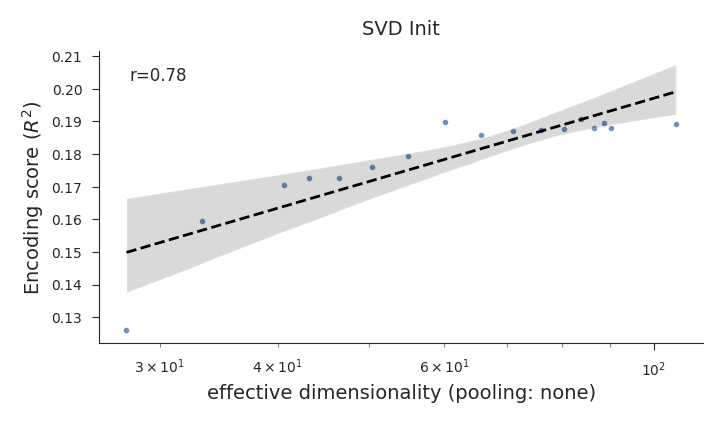

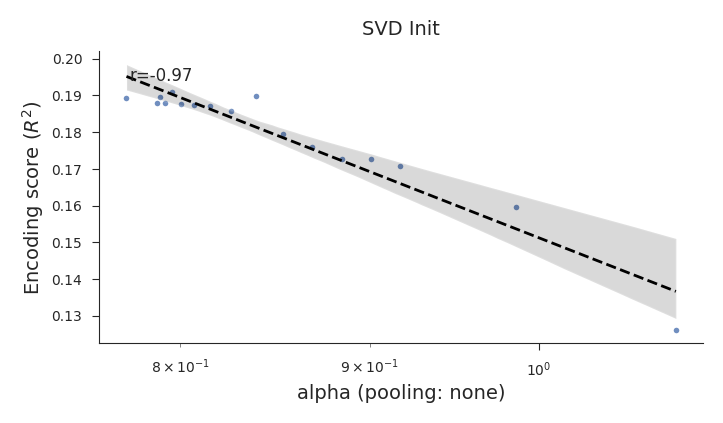

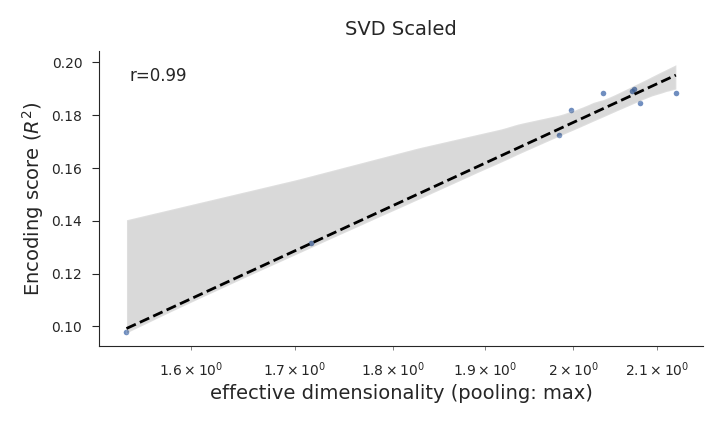

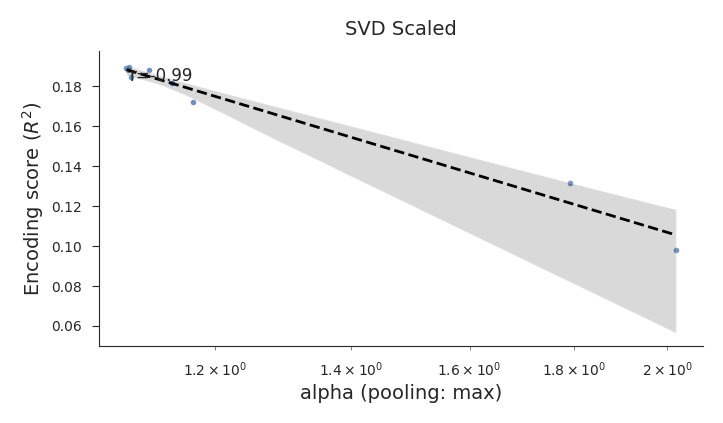

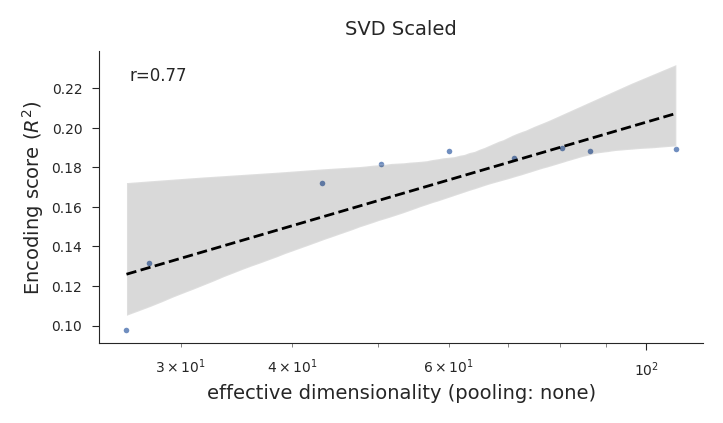

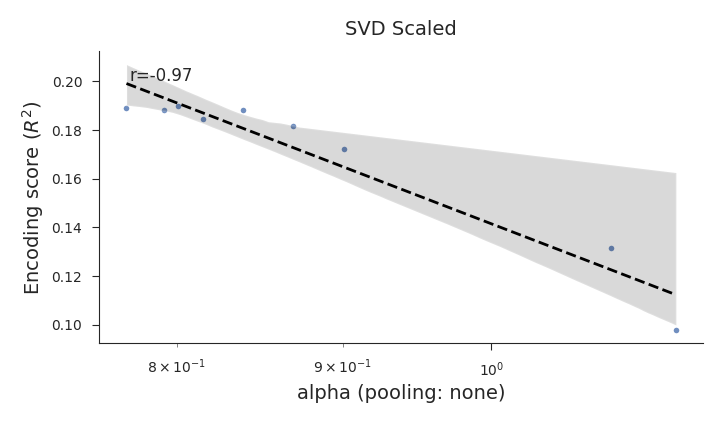

In [3]:
file = ['alpha', 'Eigall',  'SVD4', 'SVD-scaled2']
#, 'alpha-O', 'SVDall', 'SVD2', 'SVD3', 'Eig2'
pooling = ['max', 'none']
#p = 'none'

for f in file:
    for p in pooling:
        spectra = False
        encoding = True
        
        if f == 'alpha':
            t = 'features = channels'
        if f == 'alpha-O':
            t = 'elements x channels'
        elif f == 'Eigall':
            t = 'features = elements'
        elif f == 'SVDall':
            t = 'SVD init'
        elif f == 'SVD2':
            t = 'SVD2'
            p = 'none'
            encoding = False
        elif f == 'SVD3':
            t = 'SVD3'
            p = 'none'
            encoding = False
        elif f == 'SVD4':
            t = 'SVD Init'
        elif f == 'Eig2':
            t = 'channels2'
        elif f == 'SVD-scaled2':
            t = 'SVD Scaled'
            
        
        #eigenspectra

        if spectra:
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            data = pd.merge(dm, ds, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')
            
            
        # Remove outlier low-variance points at the final PCs
            def is_outlier(i):
                i = np.log(i)
                cutoff = 0.95 * i.iloc[-1]
                return i > cutoff
            outlier = data.groupby(id_columns)['n'].transform(is_outlier)
            data = data[~outlier]

        # Set y-intercept to 1
            def get_scaled_var(x):
                i, y = x['n'].values, x['variance'].values
                i, y = np.log(i), np.log(y)
                intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                intercept = np.exp(intercept)
                return x['variance'] / intercept
            scaled_var = data.groupby(id_columns).apply(get_scaled_var)
            scaled_var = scaled_var.reset_index(id_columns, drop=True)
            data['scaled_variance'] = scaled_var

        # Log(ED)
            data['log_ed'] = np.log10(data['effective dimensionality'])

            fig, ax = plt.subplots(figsize=(3, 3))
            sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                        units='id', alpha=0.2, estimator=None,
                        palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
            ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
            ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
            ax.set_ylim(bottom=10**(-9), top=10**4)
            ax.legend(title=r'$\log{(ED)}$')
            #plt.show()
            
            
        #encoding score
        
        if encoding:
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling: {p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

    plt.show()

In [16]:
import pandas as pd
#file1 = 'f10-1000'
#file2 = 'f10k'
pooling = 'none'
#max, metrics

d1 = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_SVD|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
d1 = d1[ (d1['task'] != 'SVD_-0.5')]
d1 = d1[ (d1['task'] != 'SVD_-1')]
#print(d1)
d2 = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_SVD<1|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
data = pd.concat((d2, d1), ignore_index=True)
data.to_csv(f'../../results_marcc/atlasnet/eigspectra_SVDall|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')


d1 = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_SVD|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
d1 = d1[ (d1['task'] != 'SVD_-0.5')]
d1 = d1[ (d1['task'] != 'SVD_-1')]
#print(d1)
d2 = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_SVD<1|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
data = pd.concat((d2, d1), ignore_index=True)
data.to_csv(f'../../results_marcc/atlasnet/eigmetrics_SVDall|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')



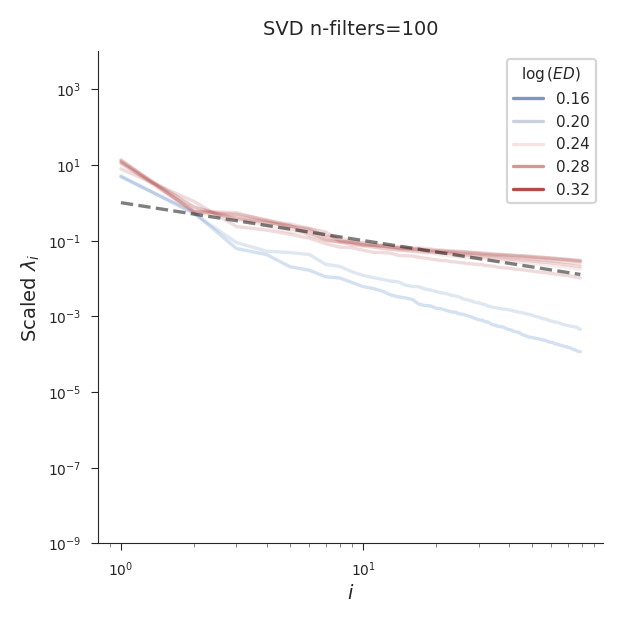

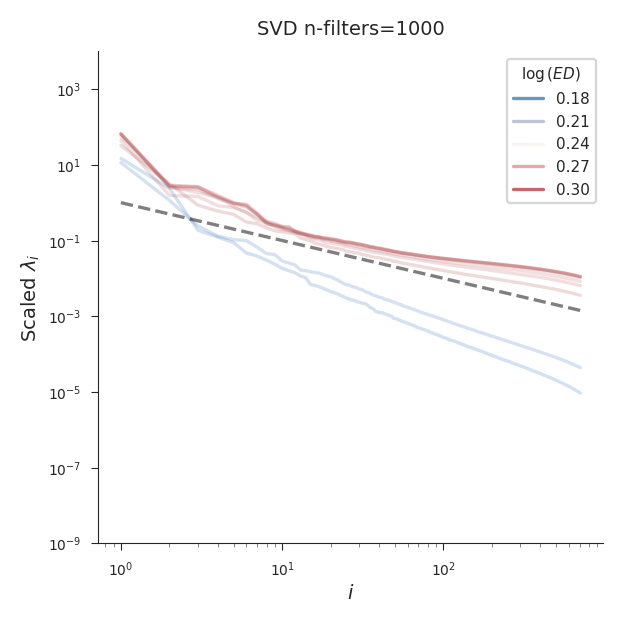

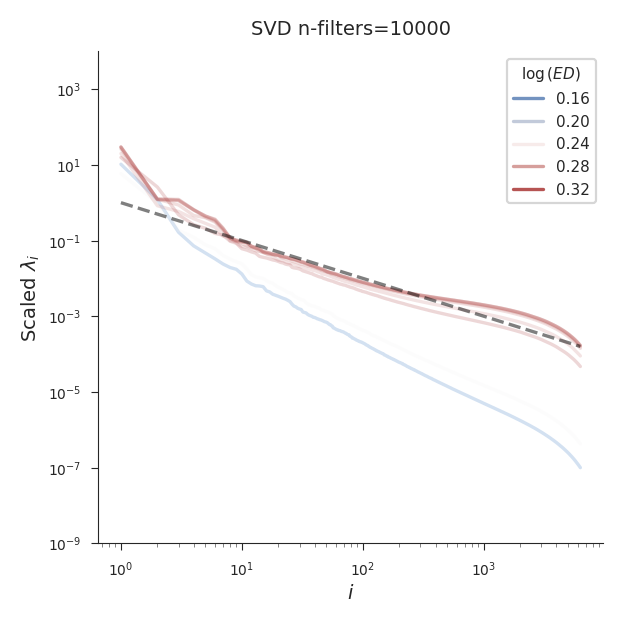

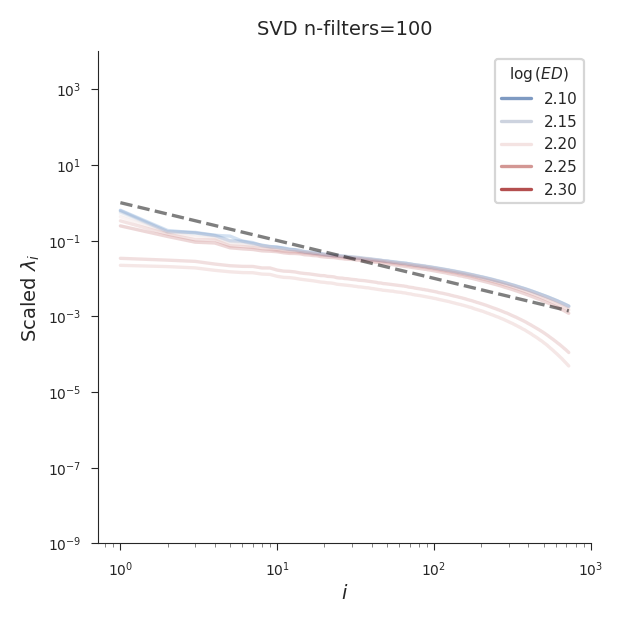

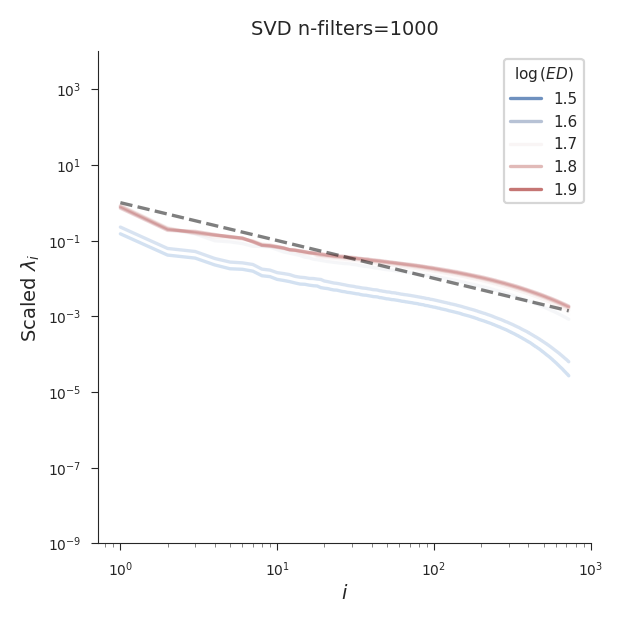

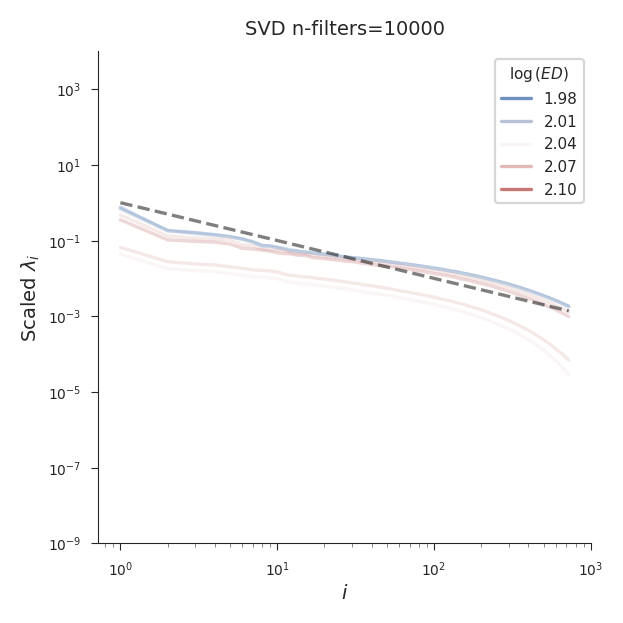

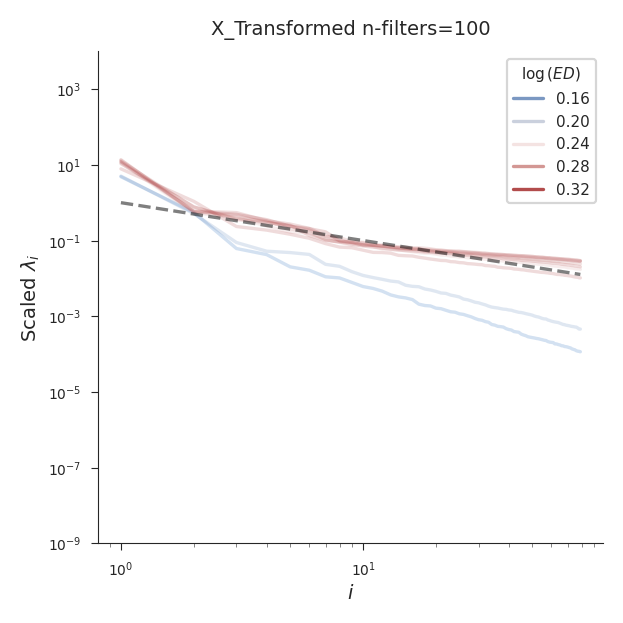

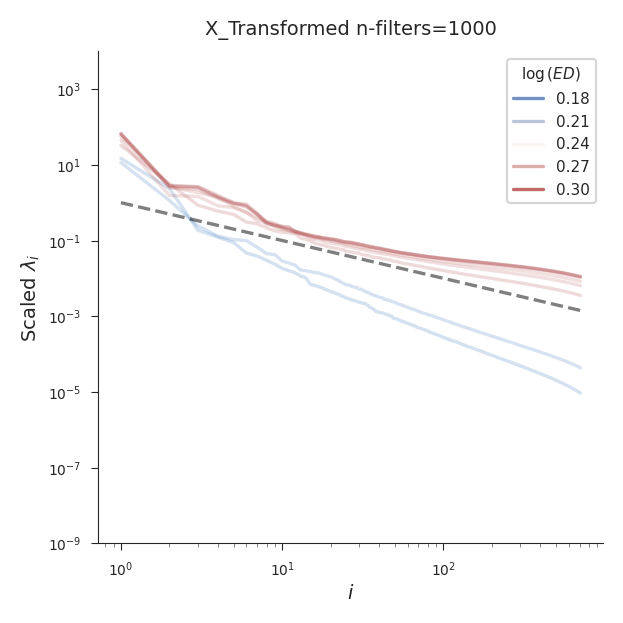

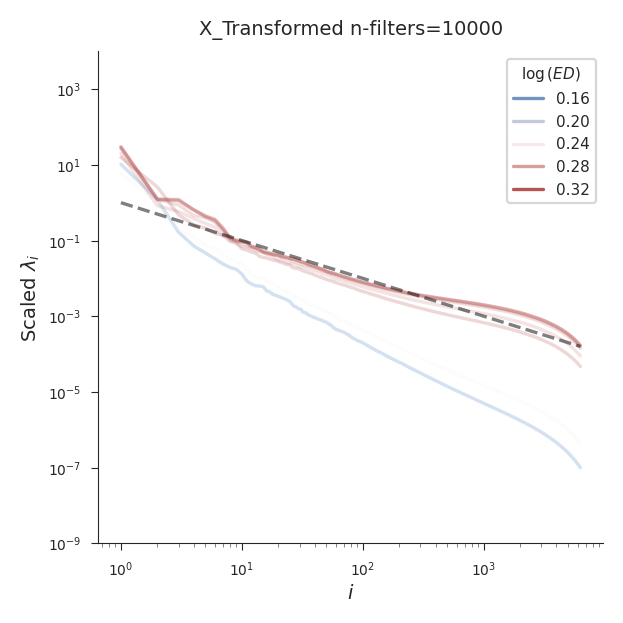

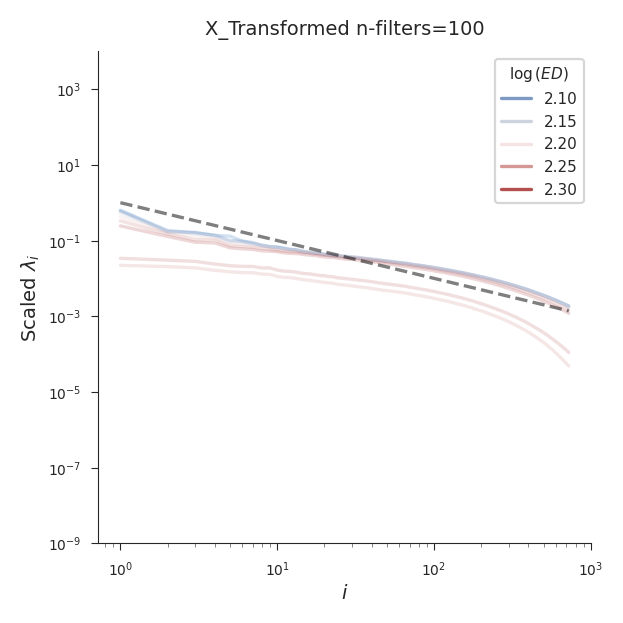

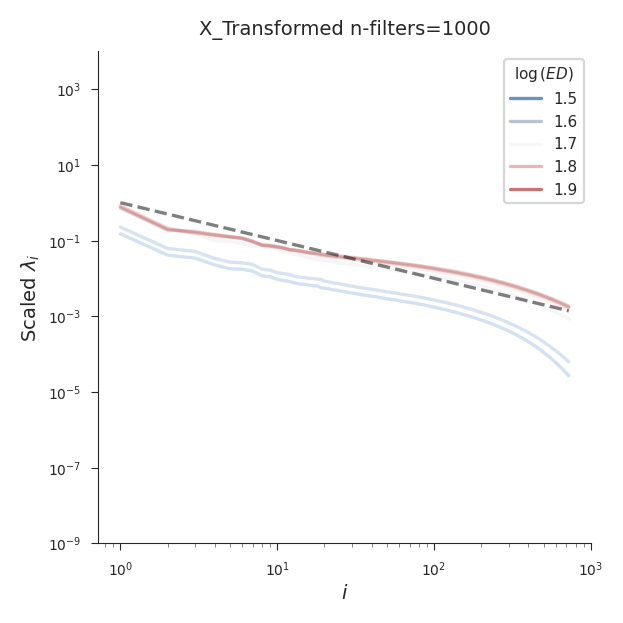

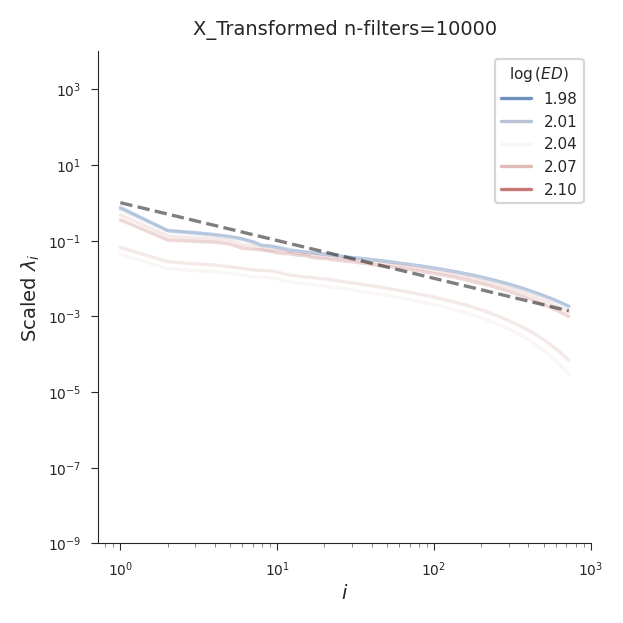

In [33]:
file = ['SVD-nf-kind', 'Eig-nf-kind']
pooling = ['max', 'none']
n_filters = [100, 1000, 10000]
#p = 'none'

for f in file:
    for p in pooling:
        for nf in n_filters:
            spectra = True
            encoding = False
            
            if f == 'SVD-nf-kind':
                t = f'SVD n-filters={nf}'
            if f == 'Eig-nf-kind':
                t = f'X_Transformed n-filters={nf}'
                
            
            #eigenspectra

            if spectra:
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
                ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
                data = pd.merge(dm, ds, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['kind']== f'nf:{nf}') ]
                data['id'] = data[id_columns].sum(axis='columns')
                
            # Remove outlier low-variance points at the final PCs
                def is_outlier(i):
                    i = np.log(i)
                    cutoff = 0.95 * i.iloc[-1]
                    return i > cutoff
                outlier = data.groupby(id_columns)['n'].transform(is_outlier)
                data = data[~outlier]

            # Set y-intercept to 1
                def get_scaled_var(x):
                    i, y = x['n'].values, x['variance'].values
                    i, y = np.log(i), np.log(y)
                    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                    intercept = np.exp(intercept)
                    return x['variance'] / intercept
                scaled_var = data.groupby(id_columns).apply(get_scaled_var)
                scaled_var = scaled_var.reset_index(id_columns, drop=True)
                data['scaled_variance'] = scaled_var

            # Log(ED)
                data['log_ed'] = np.log10(data['effective dimensionality'])

                fig, ax = plt.subplots(figsize=(3, 3))
                sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                            units='id', alpha=0.2, estimator=None,
                            palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
                ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
                ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
                ax.set_ylim(bottom=10**(-9), top=10**4)
                ax.legend(title=r'$\log{(ED)}$')
                #plt.show()
                
                
            #encoding score
            
            if encoding:
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
                de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
                data = pd.merge(de, dm, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data['id'] = data[id_columns].sum(axis='columns')

                predictors = ['effective dimensionality', 'alpha']
                for pred in predictors:
                    r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                    sns.regplot(data=data, x=pred, y='score', 
                                logx=True,
                                scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                                ax=ax)
                    ax.set(xlabel=f'{pred} (pooling: {p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                    ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                    #ax.set_ylim(bottom=0, top=0.65)
                    #ax.set_xlim(0.8, 270)

    plt.show()

In [32]:
f = 'Eig-filters'
p = 'none'
alphas = [-0.2, -0.4, -0.6, -0.8, -1.0, -1.2, -1.4, -1.6 -2, -3]
n_filters = [100,1000,10000]
    
dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
for a in alphas:
    for nf in n_filters:
        dm.loc[dm['task'] == f'Eig{a}_filters{nf}', 'kind'] = f'nf:{nf}'
        ds.loc[ds['task'] == f'Eig{a}_filters{nf}', 'kind'] = f'nf:{nf}'

dm.to_csv(f'../../results_marcc/atlasnet/eigmetrics_Eig-nf-kind|dataset:imagenet|pooling:{p}|grayscale:False.csv', index=False)
ds.to_csv(f'../../results_marcc/atlasnet/eigspectra_Eig-nf-kind|dataset:imagenet|pooling:{p}|grayscale:False.csv', index=False)



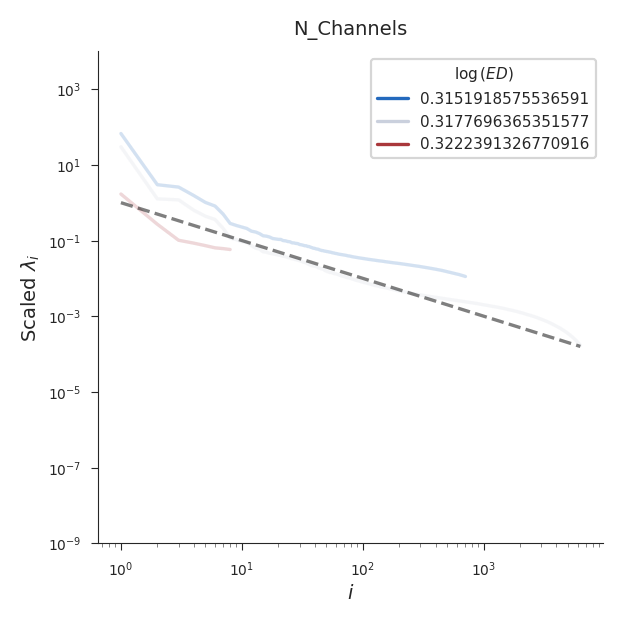

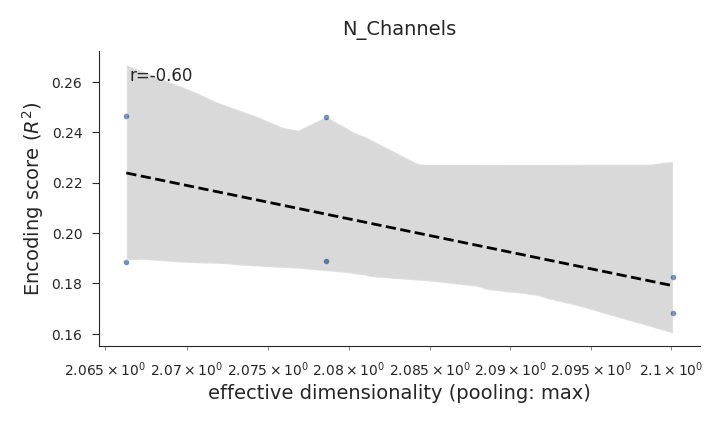

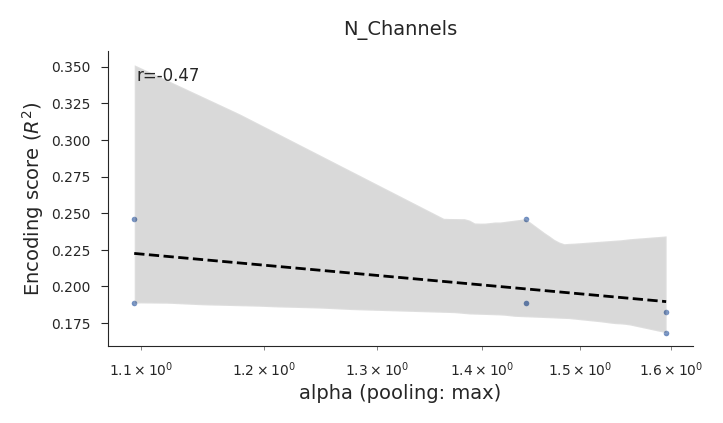

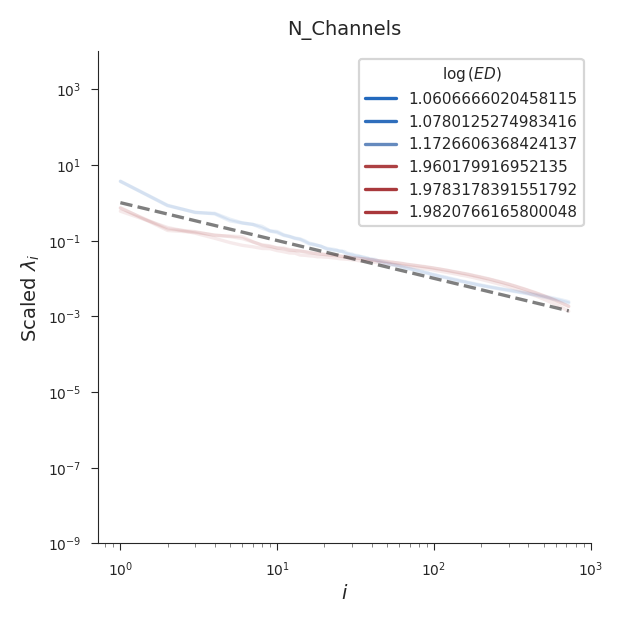

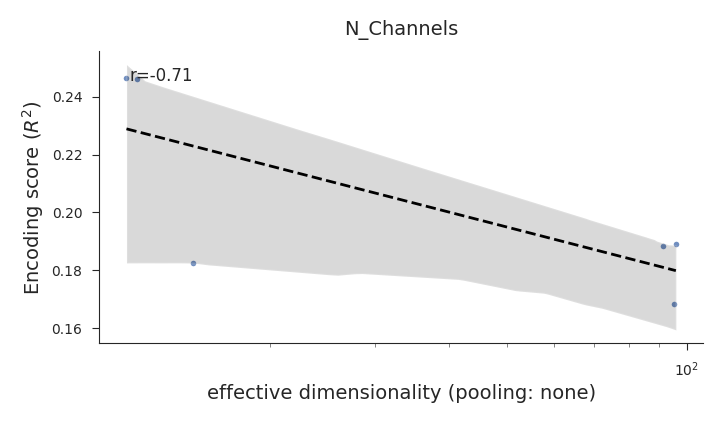

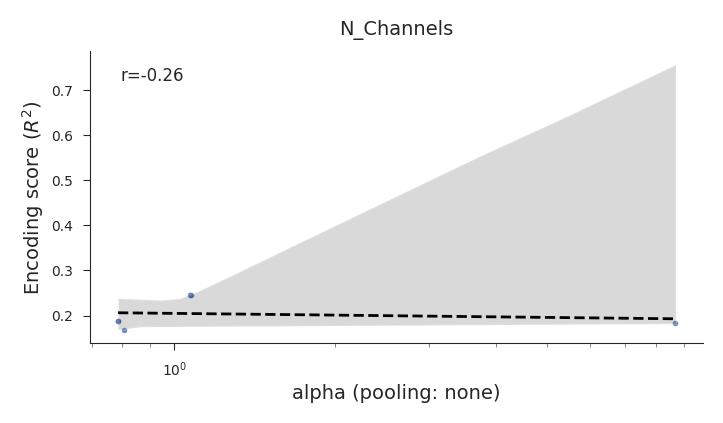

In [17]:

file = 'filters'
pooling = ['max', 'none']
spectra = True
encoding = True

#dm = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{file}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
#ds = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{file}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
for p in pooling:
    data = pd.merge(pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{file}|dataset:imagenet|pooling:{p}|grayscale:False.csv'),
                    pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{file}|dataset:imagenet|pooling:{p}|grayscale:False.csv'),
                    on=id_columns)
    data['id'] = data[id_columns].sum(axis='columns')
    #data = data[ (data['layer']=='c2') ]


    #plot eigenspectra

    if spectra:
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                    units='id', alpha=0.1, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='N_Channels')
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
        
        
    #encoding score
    if encoding:
        
        data = pd.merge(pd.read_csv(f'../../results_marcc/atlasnet/encoding_{file}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv'),
                        pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{file}|dataset:imagenet|pooling:{p}|grayscale:False.csv'),
                        on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')

        xs = ['effective dimensionality', 'alpha']
        for x in xs:
            r, p_val = sp.stats.pearsonr(data[x], data['score'])

            fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
            sns.regplot(data=data, x=x, y='score', 
                        logx=True,
                        scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                        line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                        ax=ax)
            ax.set(xlabel=f'{x} (pooling: {p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title='N_Channels')
            ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
            #ax.set_ylim(bottom=0, top=0.65)
            #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:97: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


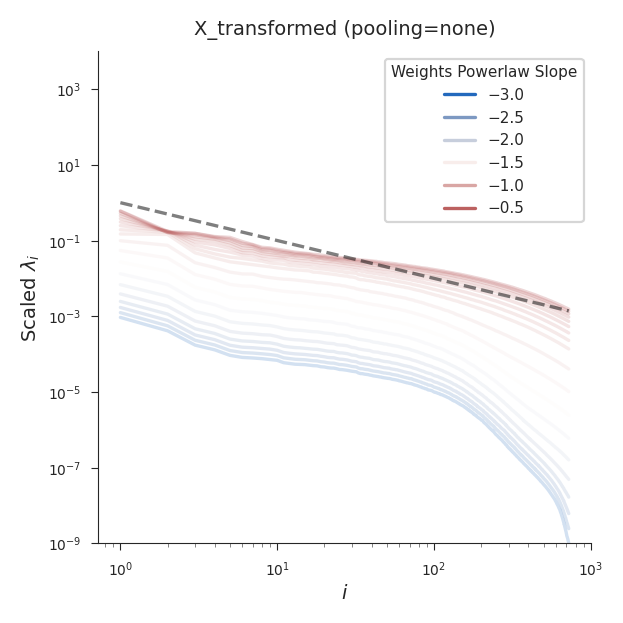

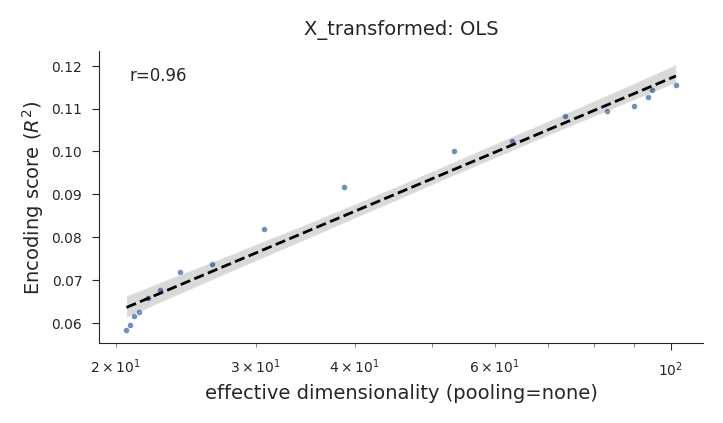

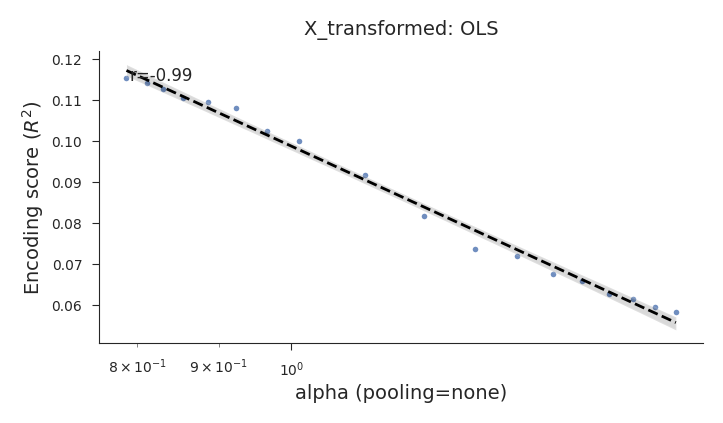

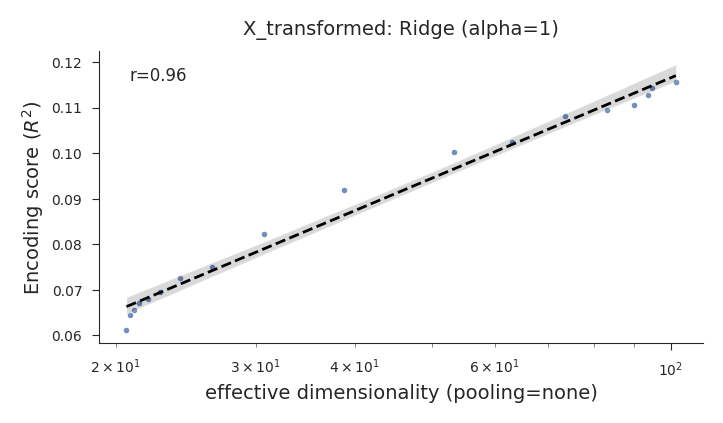

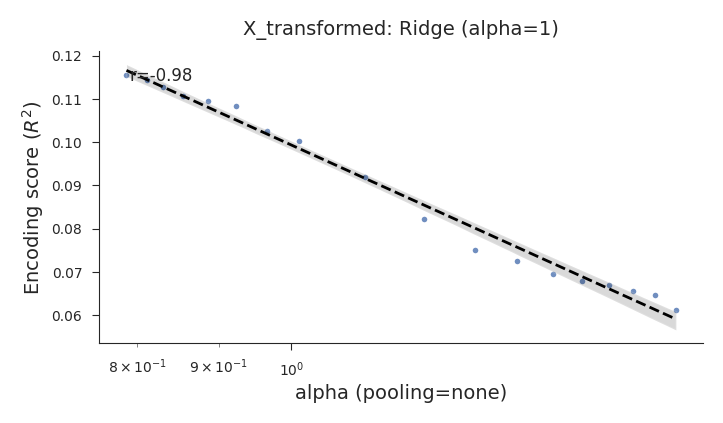

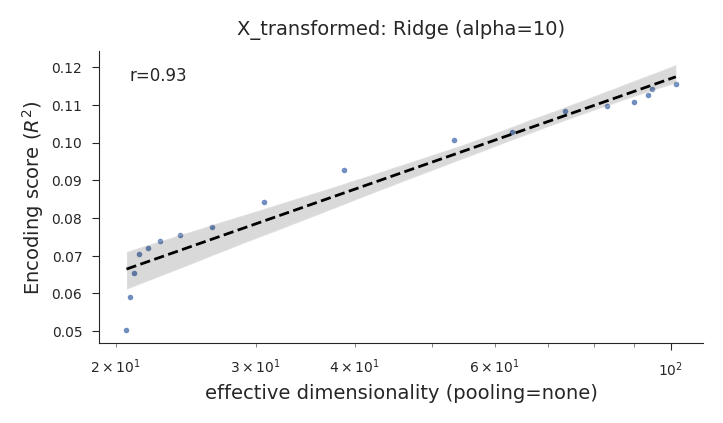

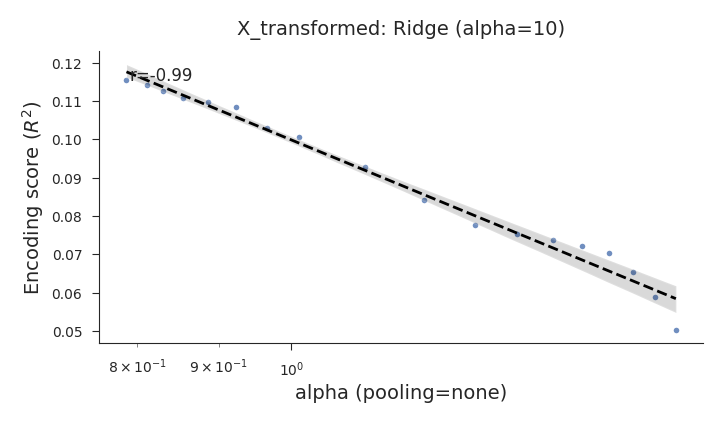

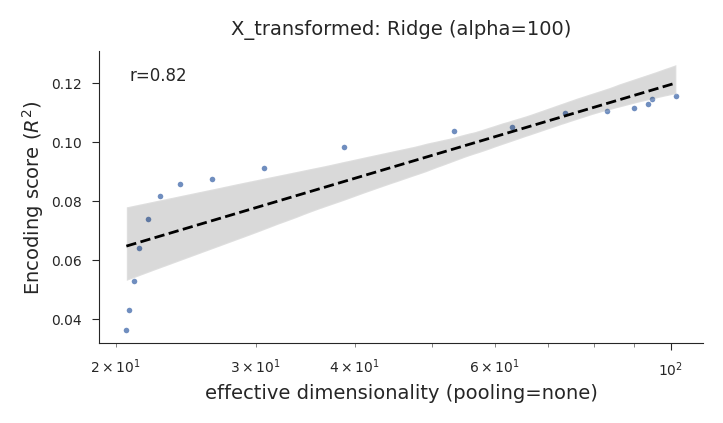

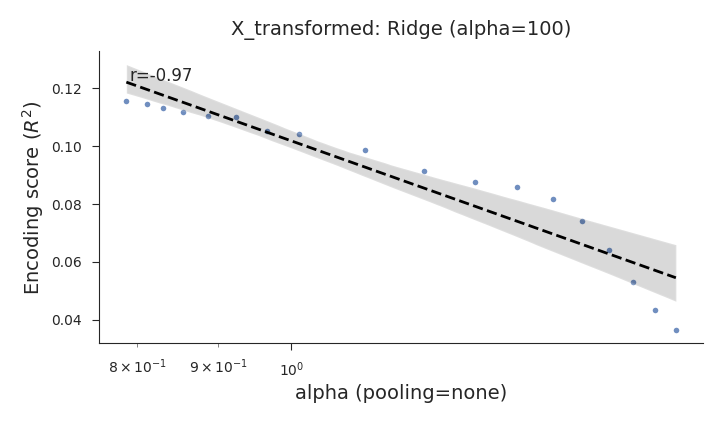

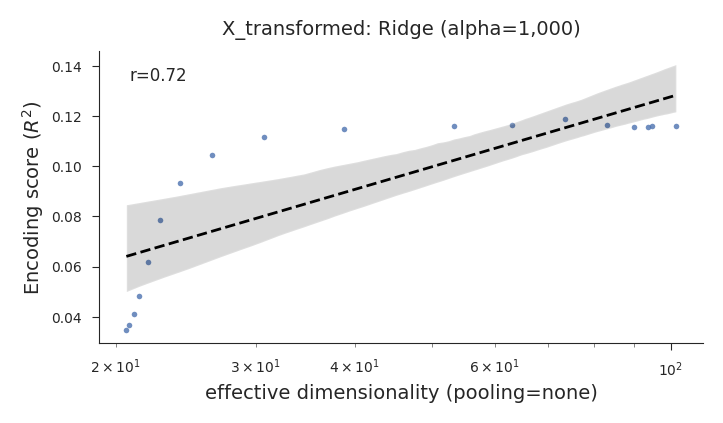

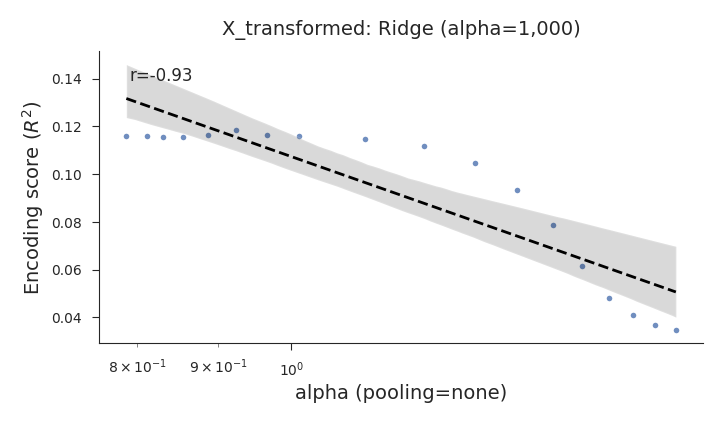

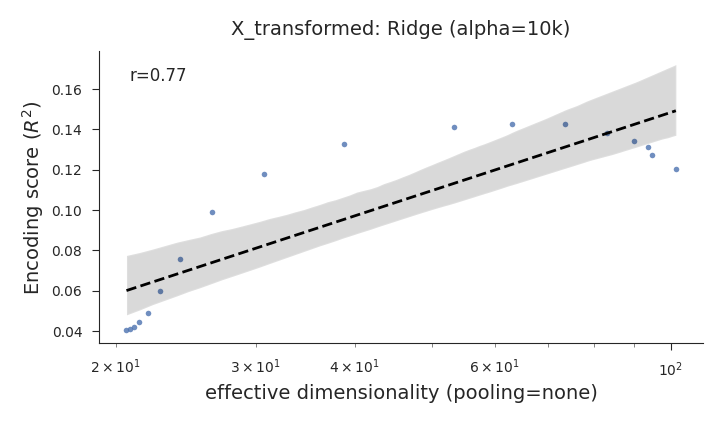

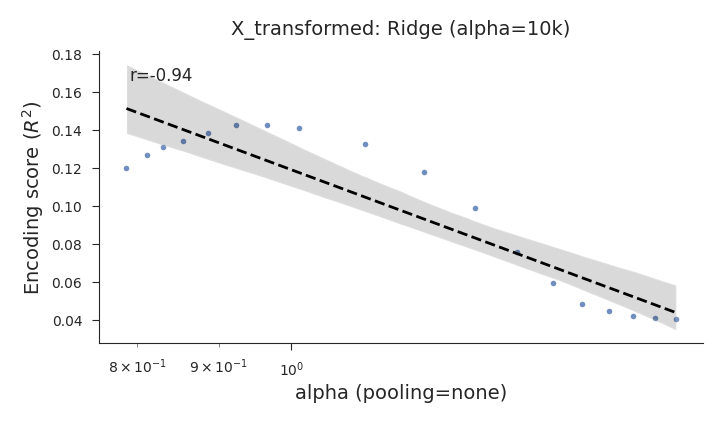

In [43]:
spec_file = 'Eig-Reg'
enc_files = ['Eig-OLS_plot', 'Eig-Ridge1_plot', 'Eig-Ridge10_plot','Eig-Ridge100_plot','Eig-Ridge1000_plot','Eig-Ridge10k_plot']
#'Eigall',  'SVD4', 'SVD-scaled2'

ridge_alphas = [1, 10, 100, 1000, 10000]
eig_slopes = [-0.2, -0,3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]

# ** set kind (or task) equal to eig_slopes for plotting hue = slope

spectra = True
encoding = True
p = 'none'


    
    #eigenspectra

if spectra:
    
    f = spec_file
    t = f'X_transformed (pooling={p})'

    dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    data = pd.merge(dm, ds, on=id_columns)
    data['id'] = data[id_columns].sum(axis='columns')
    data = data[ (data['layer']=='c2') ]
    
# Remove outlier low-variance points at the final PCs
    def is_outlier(i):
        i = np.log(i)
        cutoff = 0.95 * i.iloc[-1]
        return i > cutoff
    outlier = data.groupby(id_columns)['n'].transform(is_outlier)
    data = data[~outlier]

# Set y-intercept to 1
    def get_scaled_var(x):
        i, y = x['n'].values, x['variance'].values
        i, y = np.log(i), np.log(y)
        intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
        intercept = np.exp(intercept)
        return x['variance'] / intercept
    scaled_var = data.groupby(id_columns).apply(get_scaled_var)
    scaled_var = scaled_var.reset_index(id_columns, drop=True)
    data['scaled_variance'] = scaled_var

# Log(ED)
    data['log_ed'] = np.log10(data['effective dimensionality'])

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                units='id', alpha=0.2, estimator=None,
                palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
    ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
    ax.set_ylim(bottom=10**(-9), top=10**4)
    ax.legend(title='Weights Powerlaw Slope')
    #ax.legend(title=r'$\log{(ED)}$')
    #plt.show()
        
        
    #encoding score
    
    if encoding:
        f_spec = spec_file
        
        for f in enc_files:

            if f == 'Eig-OLS_plot':
                t = 'X_transformed: OLS'
                reg = 'lin'
            elif f == 'Eig-Ridge1_plot':
                t = 'X_transformed: Ridge (alpha=1)'
                reg = 'ridge_alpha=1'
            elif f == 'Eig-Ridge10_plot':
                t = 'X_transformed: Ridge (alpha=10)'
                reg = 'ridge_alpha=10'
            elif f == 'Eig-Ridge100_plot':
                t = 'X_transformed: Ridge (alpha=100)'
                reg = 'ridge_alpha=100'
            elif f == 'Eig-Ridge1000_plot':
                t = 'X_transformed: Ridge (alpha=1,000)'
                reg = 'ridge_alpha=1000'
            elif f == 'Eig-Ridge10k_plot':
                t = 'X_transformed: Ridge (alpha=10k)'
                reg = 'ridge_alpha=10000'
        
        
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            dm = dm[ (dm['task'] != 'Eig-Reg_-0.3')]
            dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


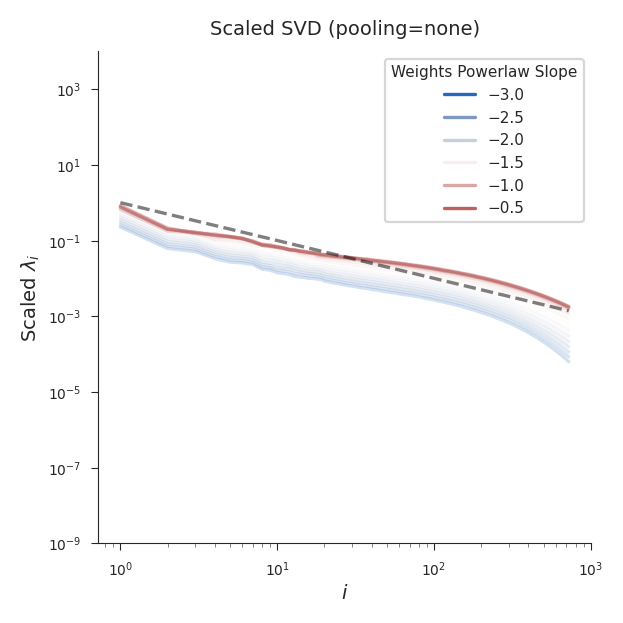

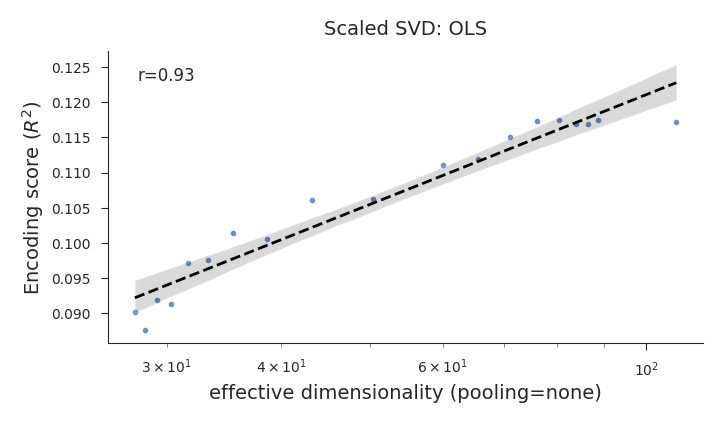

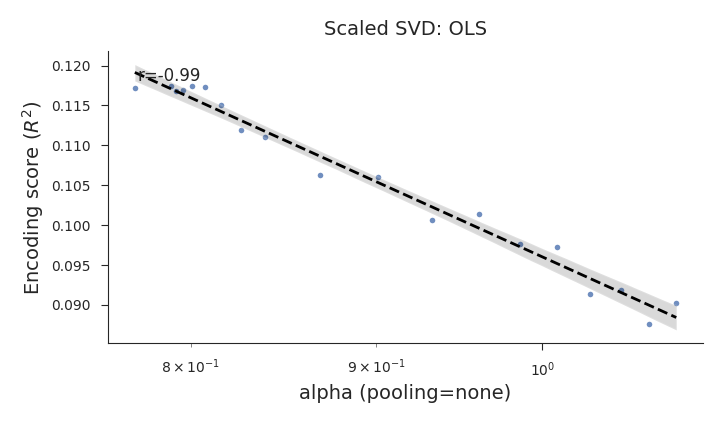

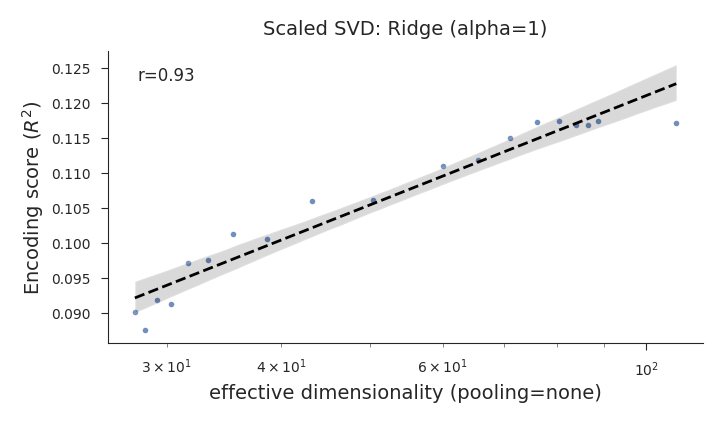

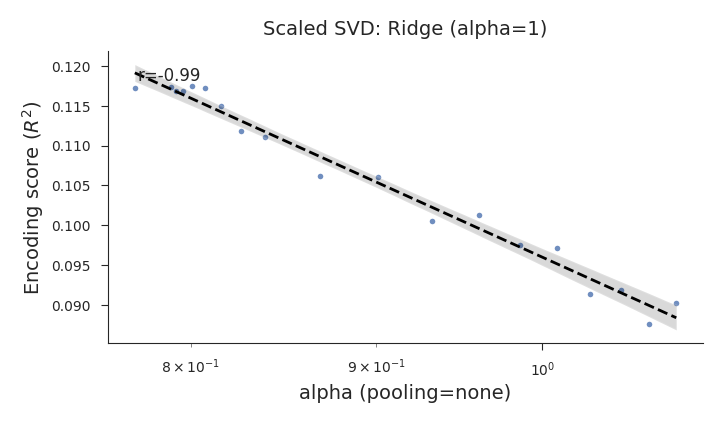

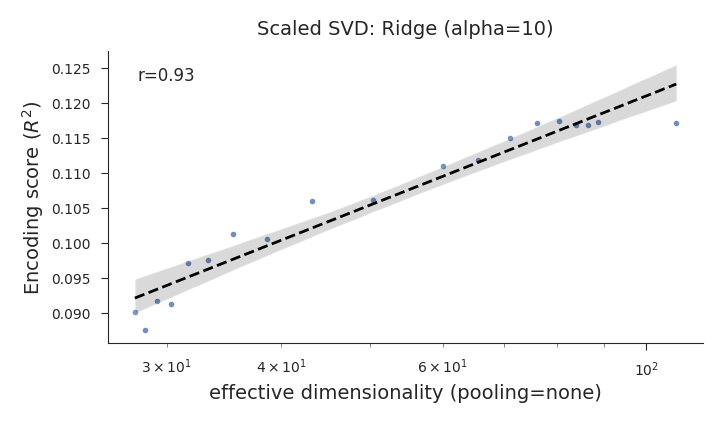

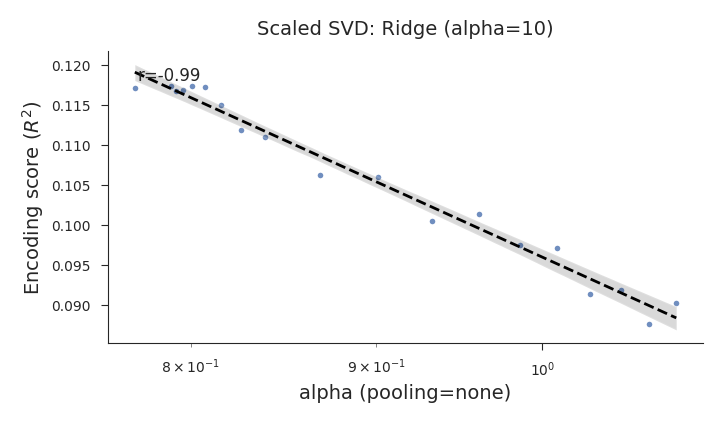

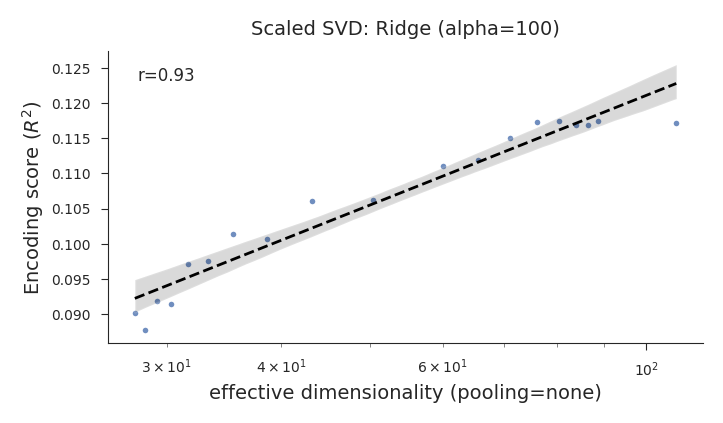

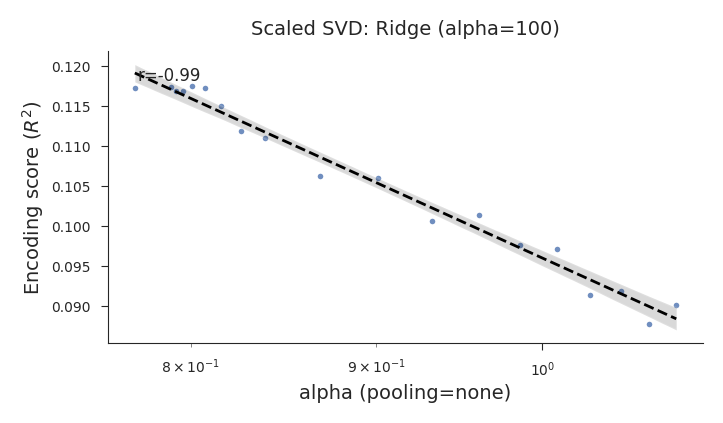

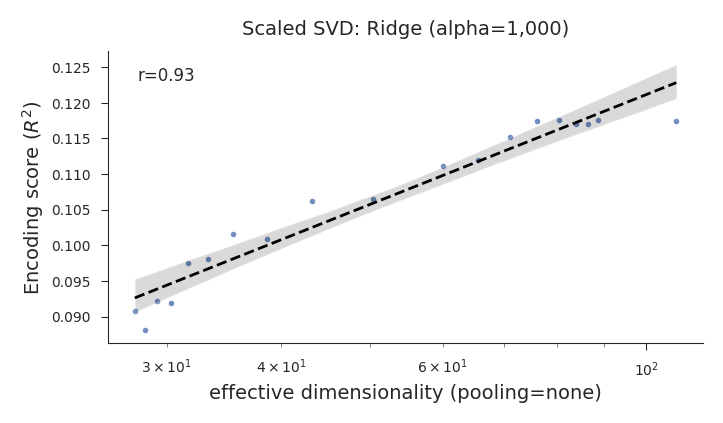

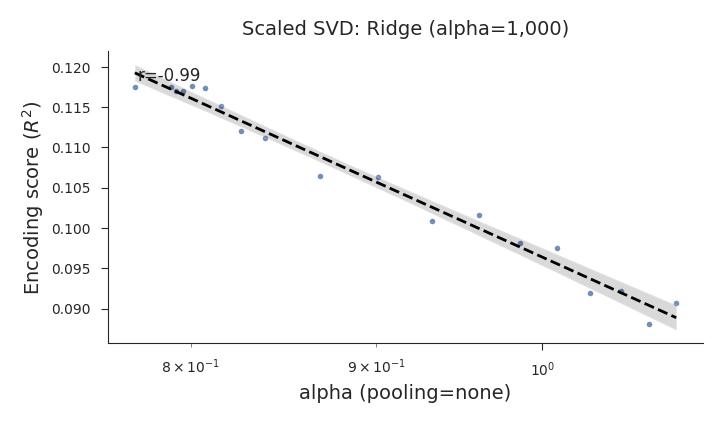

In [46]:
#spec_file = 'SVD-Reg'
spec_file = 'ScaledSVD-Reg'
#enc_files = ['SVD-OLS_plot', 'SVD-Ridge1', 'SVD-Ridge10', 'SVD-Ridge100', 'SVD-Ridge1000']
enc_files = ['ScaledSVD-OLS', 'ScaledSVD-Ridge1', 'ScaledSVD-Ridge10', 'ScaledSVD-Ridge100', 'ScaledSVD-Ridge1000']
#'Eigall',  'SVD4', 'SVD-scaled2'

spectra = True
encoding = True
p = 'none'


#eigenspectra

if spectra:
    
    f = spec_file
    if f == 'SVD-Reg':
        t = f'SVD (pooling={p})'
    if f == 'ScaledSVD-Reg':
        t = f'Scaled SVD (pooling={p})'

    dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    data = pd.merge(dm, ds, on=id_columns)
    data['id'] = data[id_columns].sum(axis='columns')
    data = data[ (data['layer']=='c2') ]
    
# Remove outlier low-variance points at the final PCs
    def is_outlier(i):
        i = np.log(i)
        cutoff = 0.95 * i.iloc[-1]
        return i > cutoff
    outlier = data.groupby(id_columns)['n'].transform(is_outlier)
    data = data[~outlier]

# Set y-intercept to 1
    def get_scaled_var(x):
        i, y = x['n'].values, x['variance'].values
        i, y = np.log(i), np.log(y)
        intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
        intercept = np.exp(intercept)
        return x['variance'] / intercept
    scaled_var = data.groupby(id_columns).apply(get_scaled_var)
    scaled_var = scaled_var.reset_index(id_columns, drop=True)
    data['scaled_variance'] = scaled_var

# Log(ED)
    data['log_ed'] = np.log10(data['effective dimensionality'])

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                units='id', alpha=0.2, estimator=None,
                palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
    ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
    ax.set_ylim(bottom=10**(-9), top=10**4)
    ax.legend(title='Weights Powerlaw Slope')
    #ax.legend(title=r'$\log{(ED)}$')
    #plt.show()
        
        
    #encoding score
    
    if encoding:
        f_spec = spec_file
        
        for f in enc_files:

            if f == 'SVD-OLS_plot':
                t = 'SVD: OLS'
                reg = 'lin'
            elif f == 'SVD-Ridge1':
                t = 'SVD: Ridge (alpha=1)'
                reg = 'ridge_alpha=1'
            elif f == 'SVD-Ridge10':
                t = 'SVD: Ridge (alpha=10)'
                reg = 'ridge_alpha=10'
            elif f == 'SVD-Ridge100':
                t = 'SVD: Ridge (alpha=100)'
                reg = 'ridge_alpha=100'
            elif f == 'SVD-Ridge1000':
                t = 'SVD: Ridge (alpha=1,000)'
                reg = 'ridge_alpha=1000'
            
            elif f == 'ScaledSVD-OLS':
                t = 'Scaled SVD: OLS'
                reg = 'lin'
            elif f == 'ScaledSVD-Ridge1':
                t = 'Scaled SVD: Ridge (alpha=1)'
                reg = 'ridge_alpha=1'
            elif f == 'ScaledSVD-Ridge10':
                t = 'Scaled SVD: Ridge (alpha=10)'
                reg = 'ridge_alpha=10'
            elif f == 'ScaledSVD-Ridge100':
                t = 'Scaled SVD: Ridge (alpha=100)'
                reg = 'ridge_alpha=100'
            elif f == 'ScaledSVD-Ridge1000':
                t = 'Scaled SVD: Ridge (alpha=1,000)'
                reg = 'ridge_alpha=1000'
        
        
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            if f == 'SVD-OLS_plot':
                dm = dm[ (dm['task'] != 'SVD-Reg_-0.3')]
                dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensional

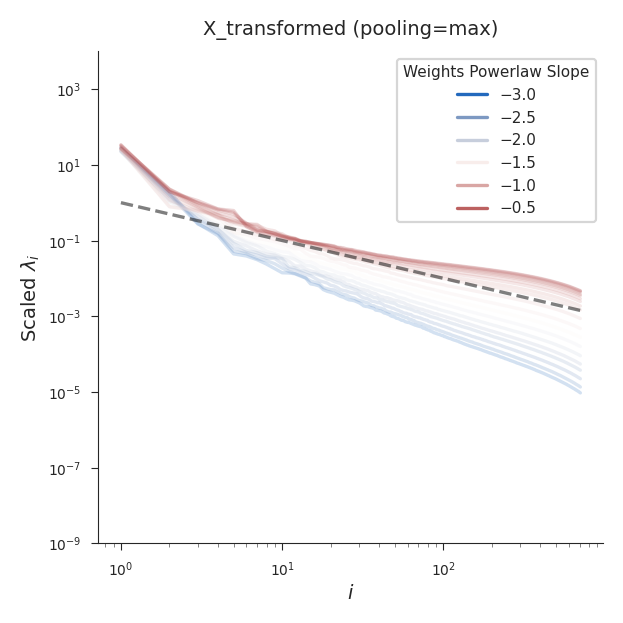

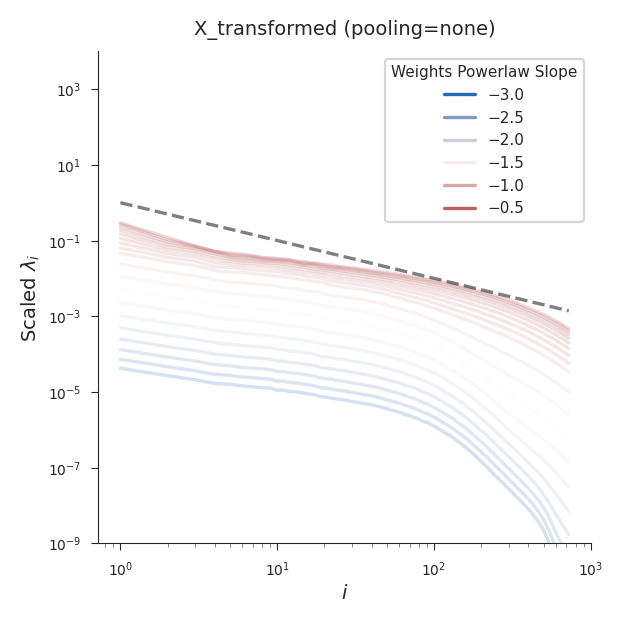

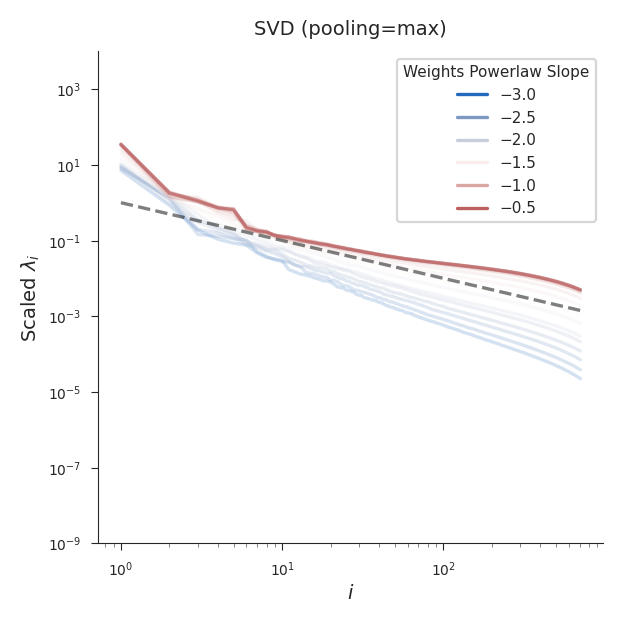

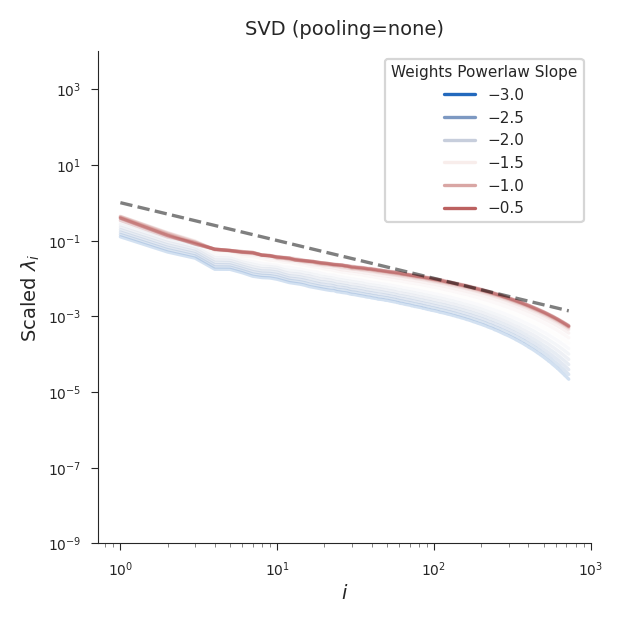

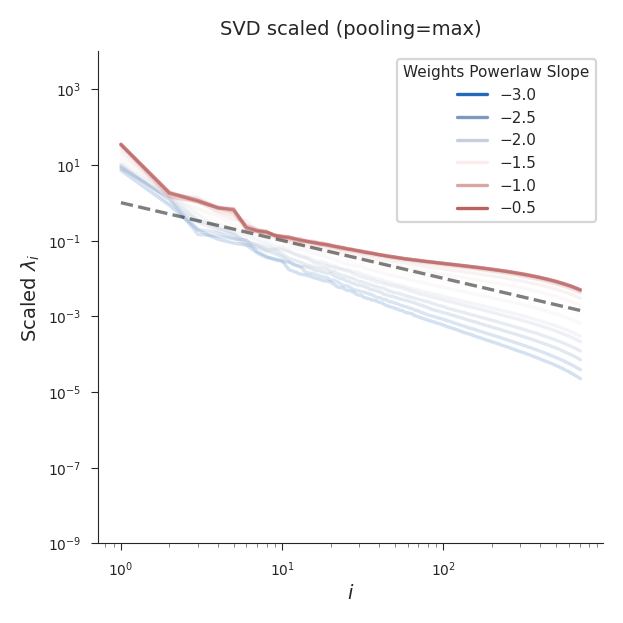

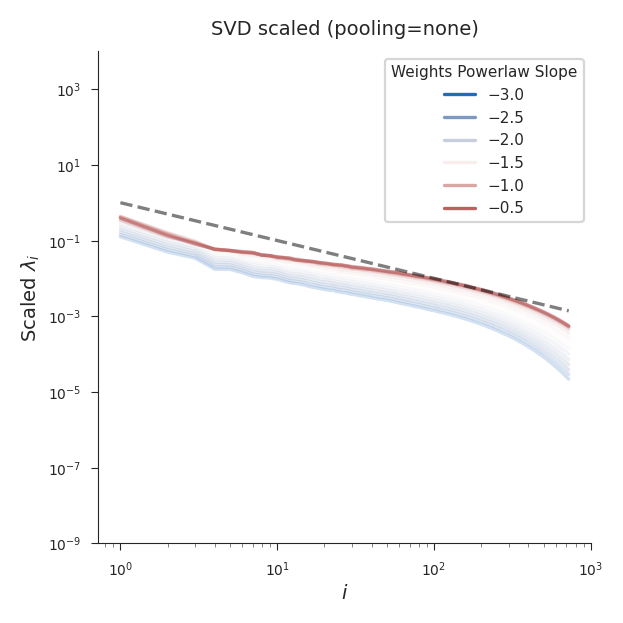

In [3]:
files = ['Eig-MH', 'SVD-MH', 'ScaledSVD-MH']
pooling = ['max', 'none']
dataset = 'majajhong2015'

spectra = True
encoding = False

for f in files:
    for p in pooling:


#eigenspectra

        if spectra:
            
            if f == 'Eig-MH':
                t = f'X_transformed (pooling={p})'
            elif f == 'SVD-MH':
                t = f'SVD (pooling={p})'
            elif f == 'ScaledSVD-MH':
                t = f'SVD scaled (pooling={p})'

            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            data = pd.merge(dm, ds, on=id_columns)
            data['id'] = data[id_columns].sum(axis='columns')
            data = data[ (data['layer']=='c2') ]
            
        # Remove outlier low-variance points at the final PCs
            def is_outlier(i):
                i = np.log(i)
                cutoff = 0.95 * i.iloc[-1]
                return i > cutoff
            outlier = data.groupby(id_columns)['n'].transform(is_outlier)
            data = data[~outlier]

        # Set y-intercept to 1
            def get_scaled_var(x):
                i, y = x['n'].values, x['variance'].values
                i, y = np.log(i), np.log(y)
                intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                intercept = np.exp(intercept)
                return x['variance'] / intercept
            scaled_var = data.groupby(id_columns).apply(get_scaled_var)
            scaled_var = scaled_var.reset_index(id_columns, drop=True)
            data['scaled_variance'] = scaled_var

        # Log(ED)
            data['log_ed'] = np.log10(data['effective dimensionality'])

            fig, ax = plt.subplots(figsize=(3, 3))
            sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                        units='id', alpha=0.2, estimator=None,
                        palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
            ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
            ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
            ax.set_ylim(bottom=10**(-9), top=10**4)
            ax.legend(title='Weights Powerlaw Slope')
            #ax.legend(title=r'$\log{(ED)}$')
            #plt.show()
                
                
            #encoding score
            
            if encoding:
                f_spec = spec_file
                
                if f == 'Eig-MH':
                    t = f'X_transformed (pooling={p})'
                elif f == 'SVD-MH':
                    t = f'SVD (pooling={p})'
                elif f == 'ScaledSVD-MH':
                        t = f'SVD scaled (pooling={p})'
                
                
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
                de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
                data = pd.merge(de, dm, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data['id'] = data[id_columns].sum(axis='columns')

                predictors = ['effective dimensionality', 'alpha']
                for pred in predictors:
                    r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                    sns.regplot(data=data, x=pred, y='score', 
                                logx=True,
                                scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                                ax=ax)
                    ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                    ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                    #ax.set_ylim(bottom=0, top=0.65)
                    #ax.set_xlim(0.8, 270)

plt.show()

In [39]:
import pandas as pd
# ** set kind (or task) equal to eig_slopes for plotting hue = slope
#get rid of Eig-OLS0, Eig-OLS3, EigRidge1_0, EigRidge1_3, etc.
file = 'SVD-OLS'
reg = 'lin'

d1 = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{file}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
d1 = d1[ (d1['task'] != 'SVD-OLS0')]
d1 = d1[ (d1['task'] != 'SVD-OLS3')]
d1.reset_index(drop=True, inplace=True)


eig_slopes = [-0.2, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]
for e in eig_slopes:
    i = eig_slopes.index(e)
    for l in range(2):
        row = i + i + l
        d1.iat[row, 5] = e

#print(d1)
d1.to_csv(f'../../results_marcc/atlasnet/encoding_{file}_plot|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')


/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


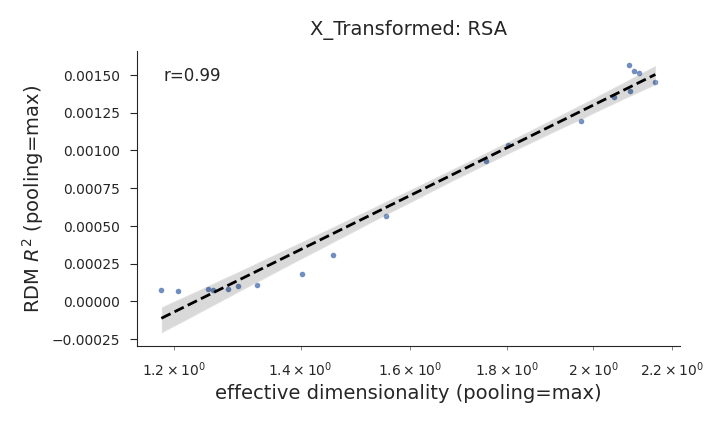

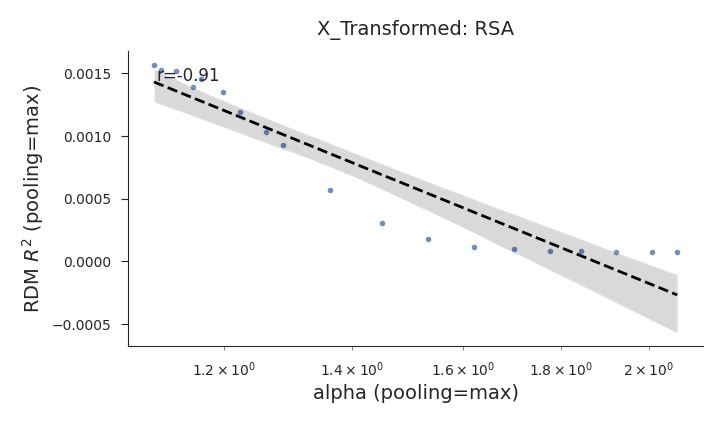

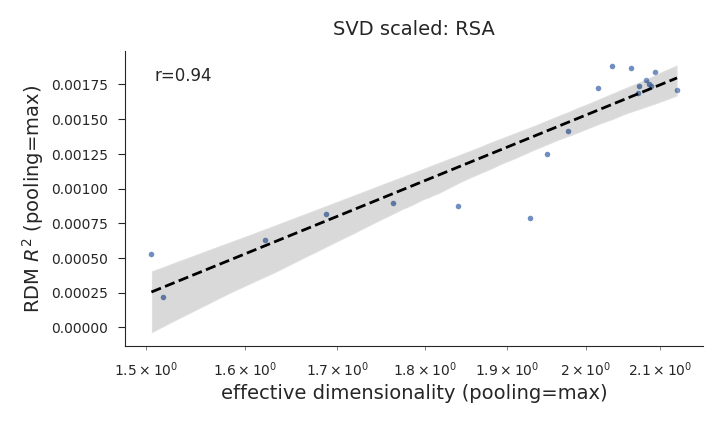

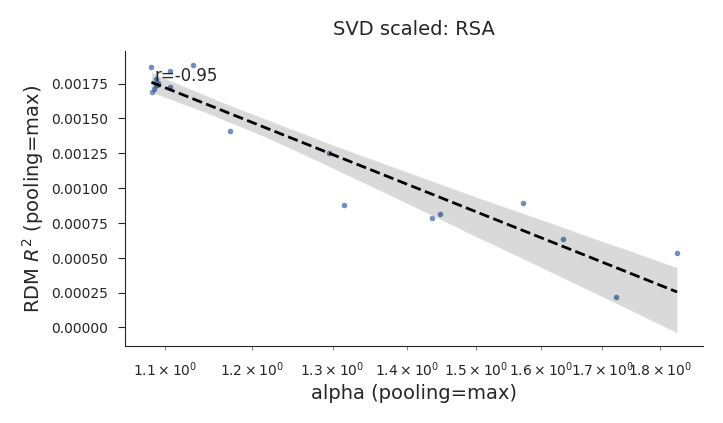

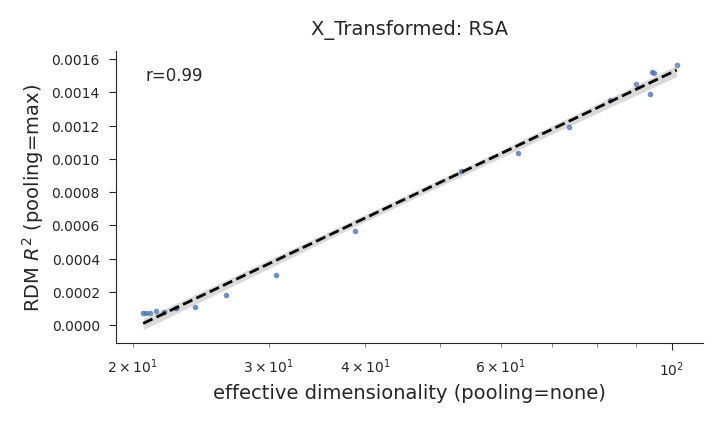

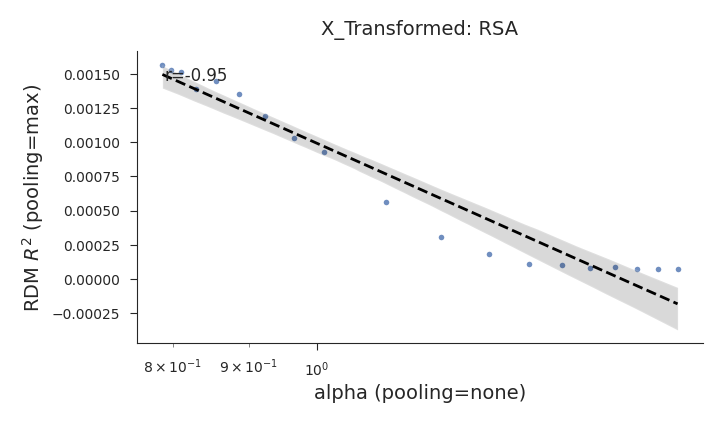

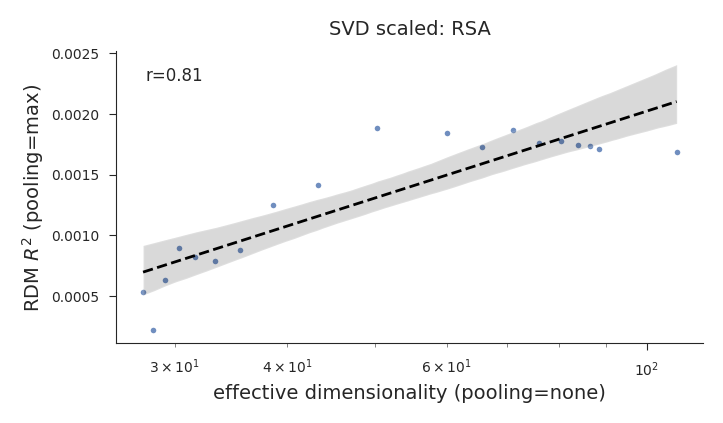

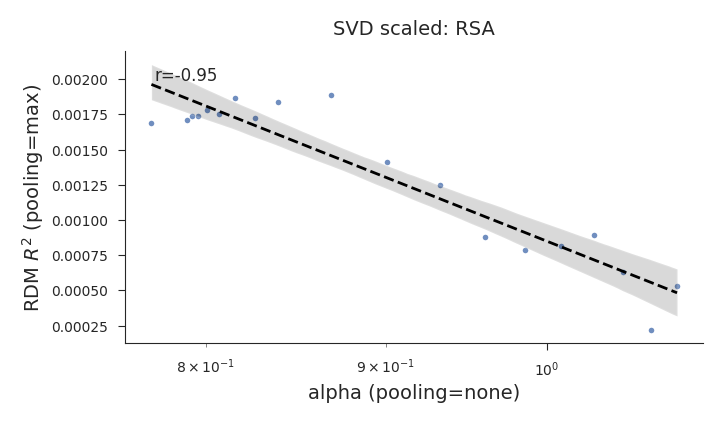

In [6]:

enc_files = ['Eig', 'SVD']
#'Eigall',  'SVD4', 'SVD-scaled2'
pooling = ['max', 'none']

spectra = False
encoding = True

for p in pooling:

    #eigenspectra

    if spectra:
        
        f = spec_file
        if f == 'SVD-Reg':
            t = f'SVD (pooling={p})'
        if f == 'ScaledSVD-Reg':
            t = f'Scaled SVD (pooling={p})'

        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title='Weights Powerlaw Slope')
        #ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
            
            
        #encoding score
        
    if encoding:
            
        for f in enc_files:

            if f == 'Eig':
                f_spec = 'Eig-Reg'
                t = 'X_Transformed: RSA'
            elif f == 'SVD':
                f_spec = 'ScaledSVD-Reg'
                t = 'SVD scaled: RSA'
                
            
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            if f == 'SVD-OLS_plot':
                dm = dm[ (dm['task'] != 'SVD-Reg_-0.3')]
                dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../results_marcc/atlasnet/rsa_{f}|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:True.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'RDM $R^2$ (pooling=max)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


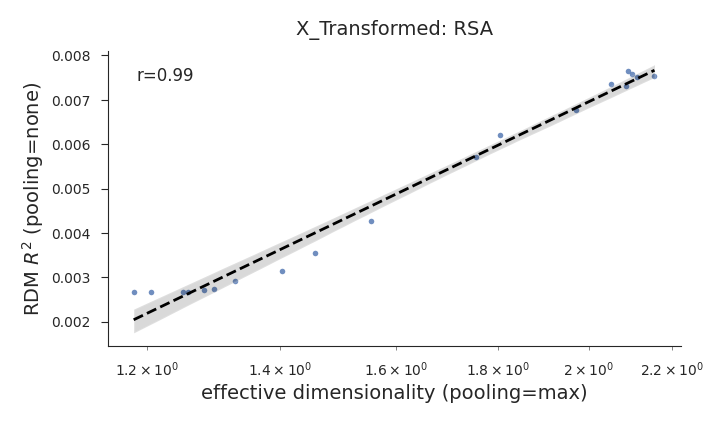

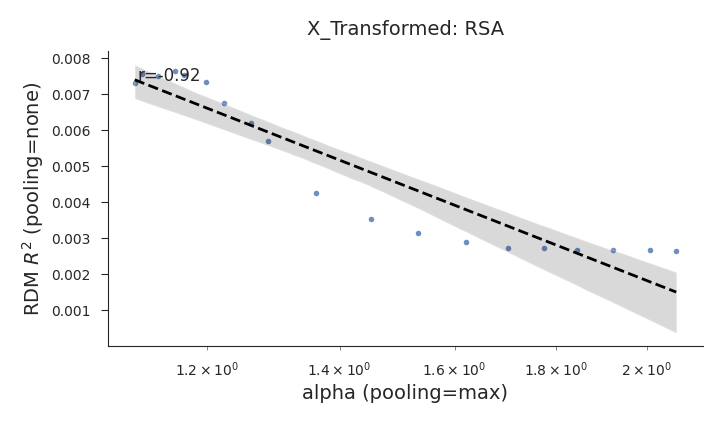

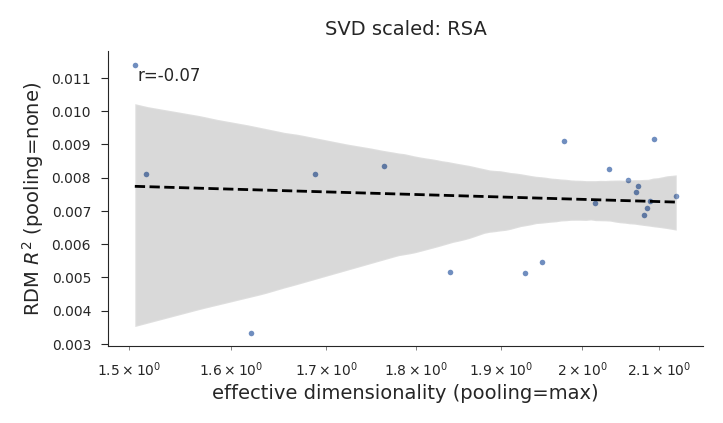

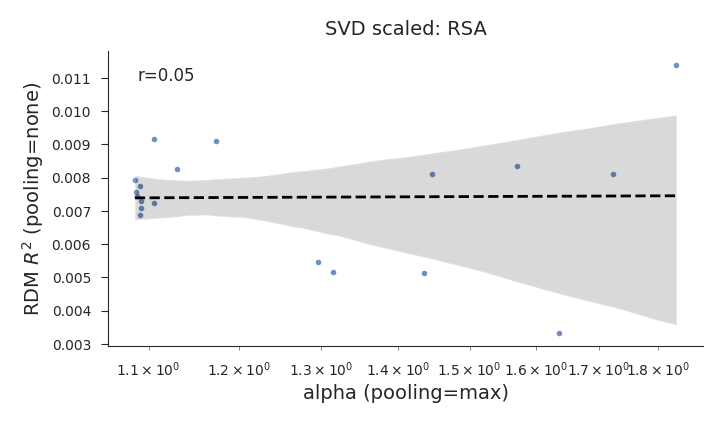

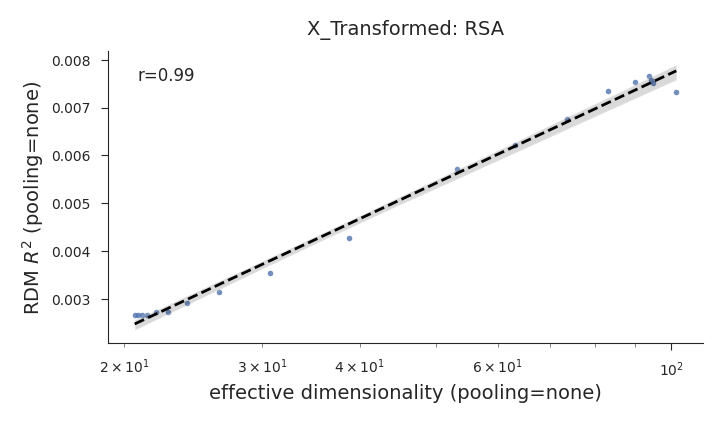

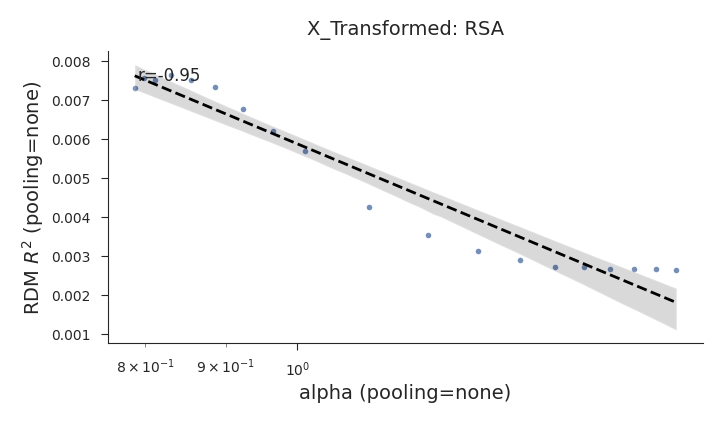

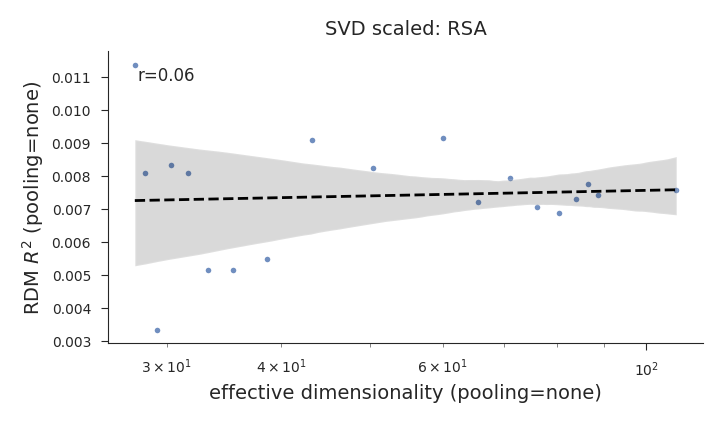

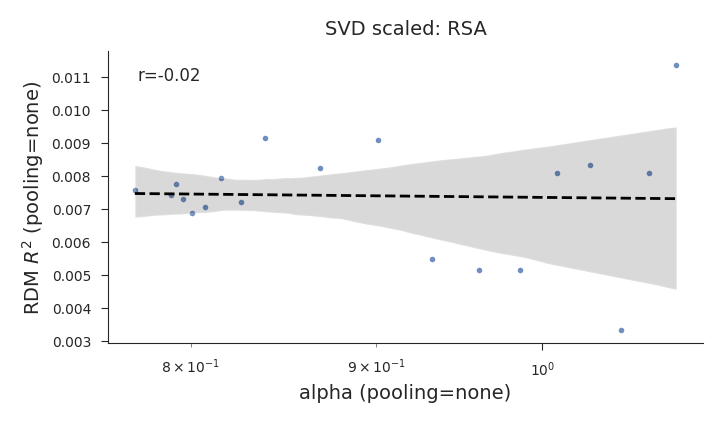

In [7]:

enc_files = ['Eig', 'SVD']
#'Eigall',  'SVD4', 'SVD-scaled2'
pooling = ['max', 'none']

spectra = False
encoding = True

for p in pooling:

    #eigenspectra

    if spectra:
        
        f = spec_file
        if f == 'SVD-Reg':
            t = f'SVD (pooling={p})'
        if f == 'ScaledSVD-Reg':
            t = f'Scaled SVD (pooling={p})'

        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title='Weights Powerlaw Slope')
        #ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
            
            
        #encoding score
        
    if encoding:
            
        for f in enc_files:

            if f == 'Eig':
                f_spec = 'Eig-Reg'
                t = 'X_Transformed: RSA'
            elif f == 'SVD':
                f_spec = 'ScaledSVD-Reg'
                t = 'SVD scaled: RSA'
                
            
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            if f == 'SVD-OLS_plot':
                dm = dm[ (dm['task'] != 'SVD-Reg_-0.3')]
                dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../results_marcc/atlasnet/rsa_{f}|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:False.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'RDM $R^2$ (pooling=none)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensional

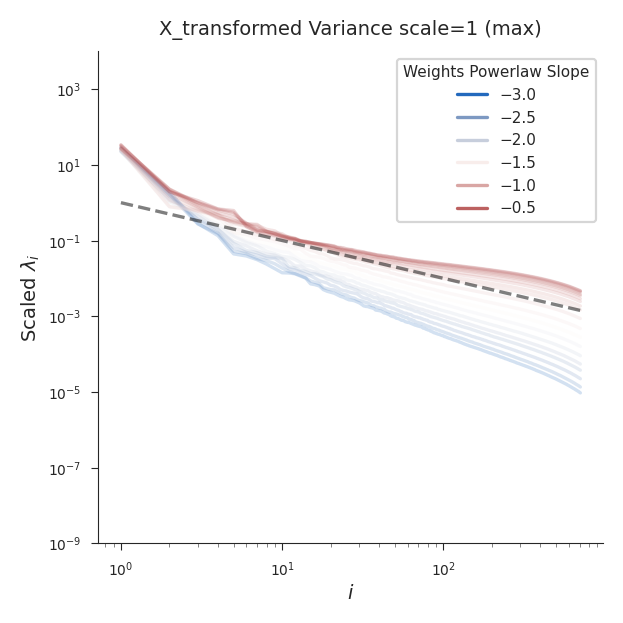

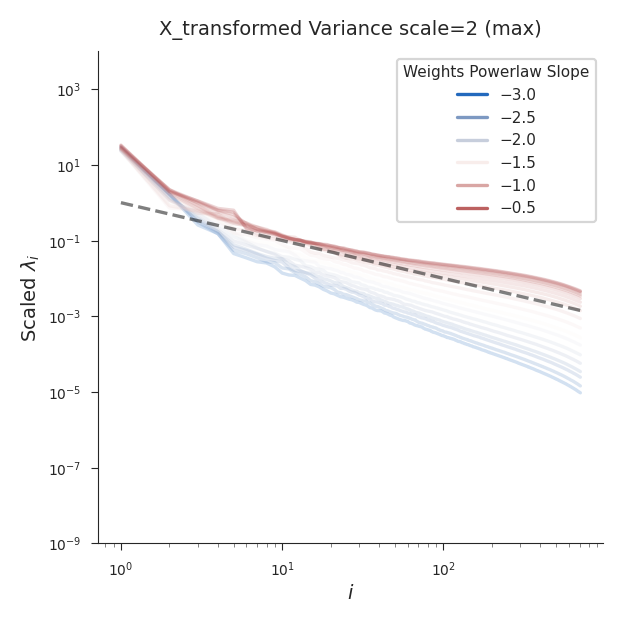

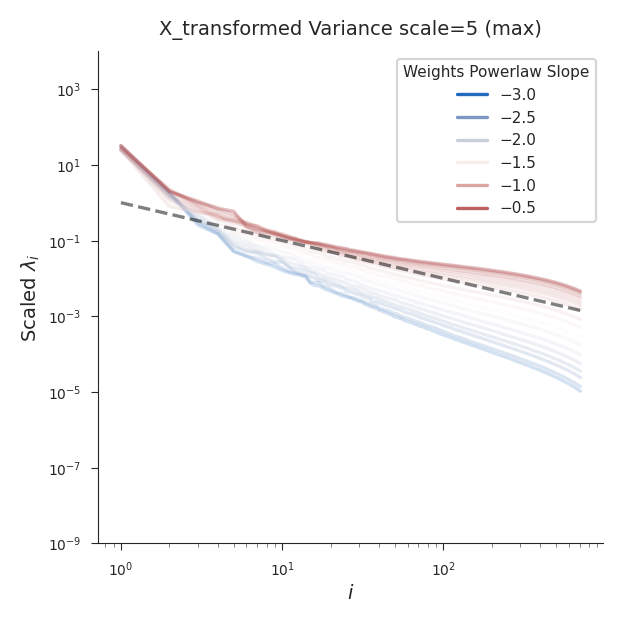

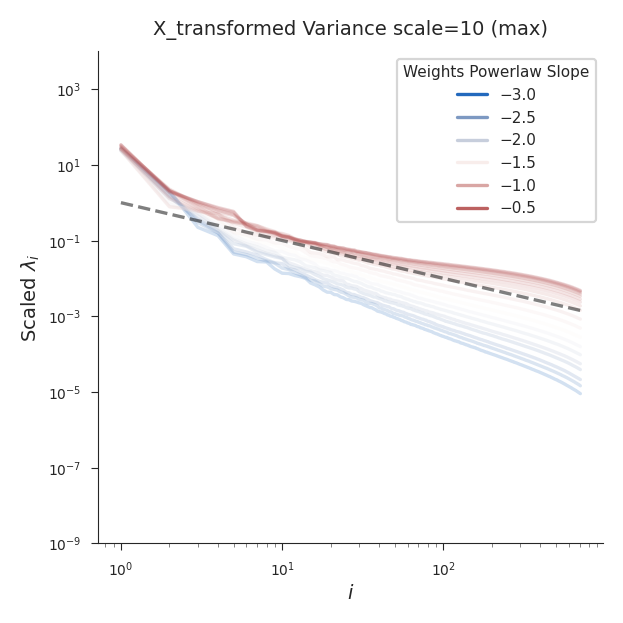

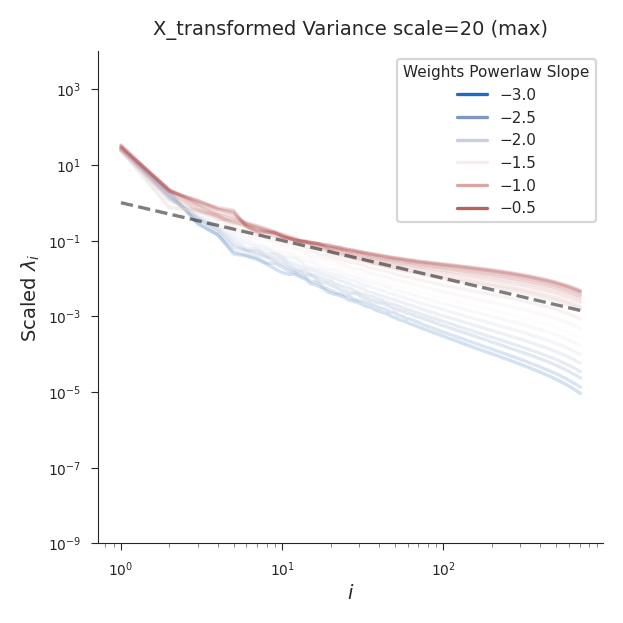

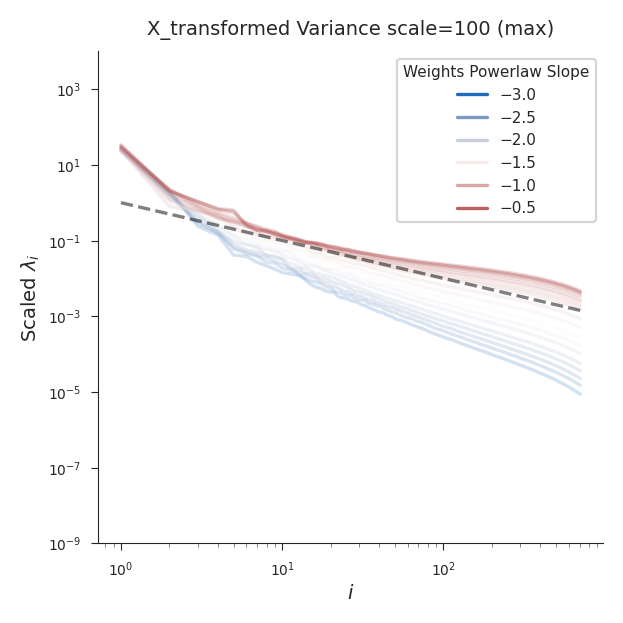

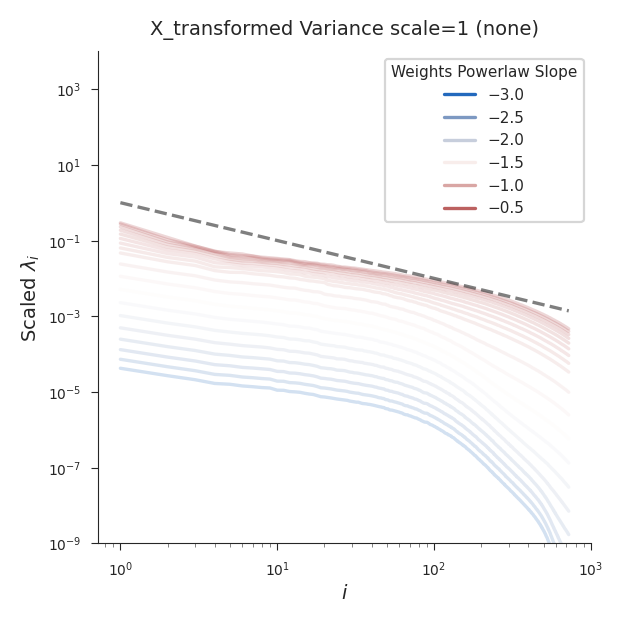

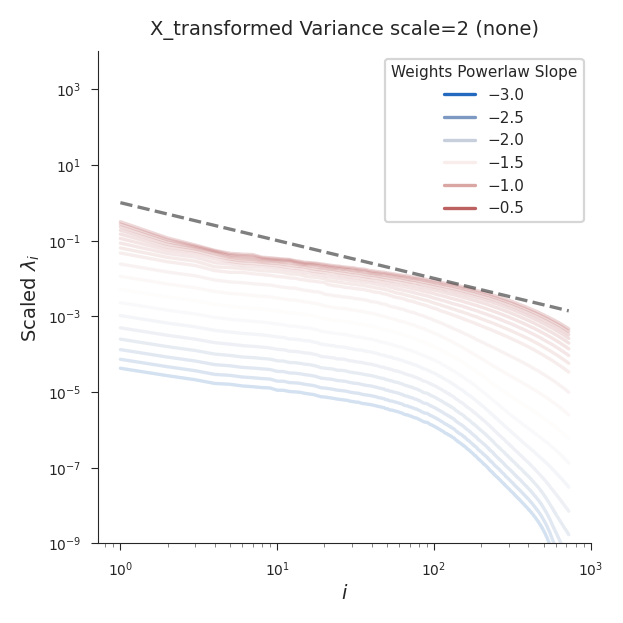

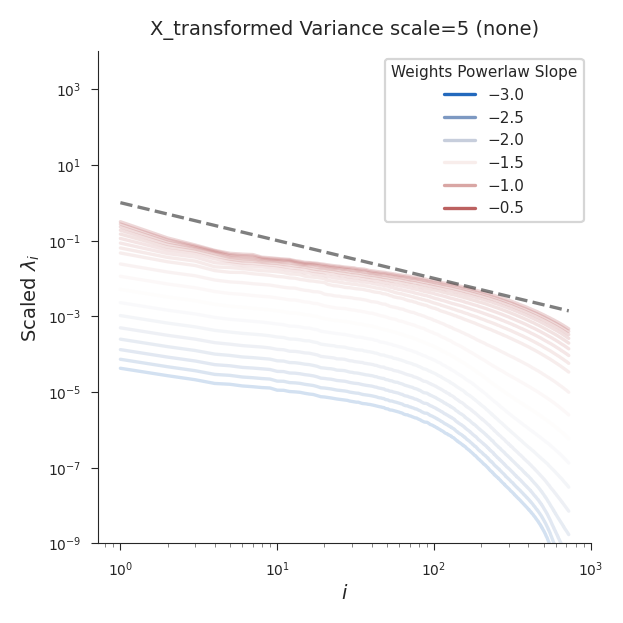

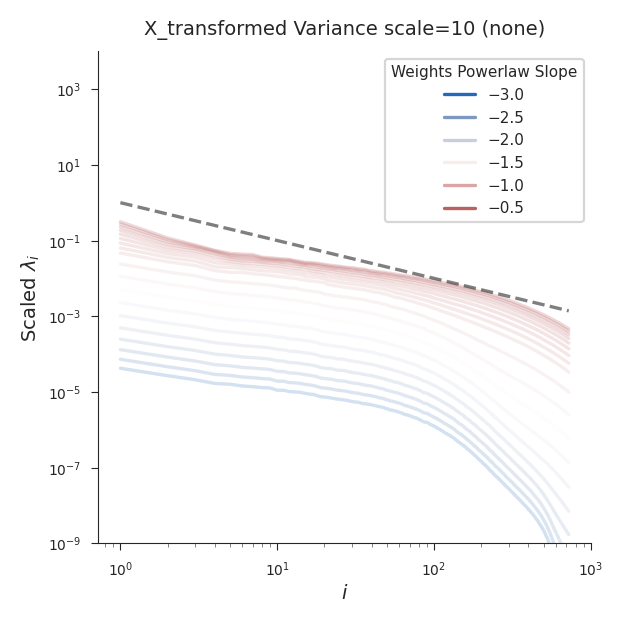

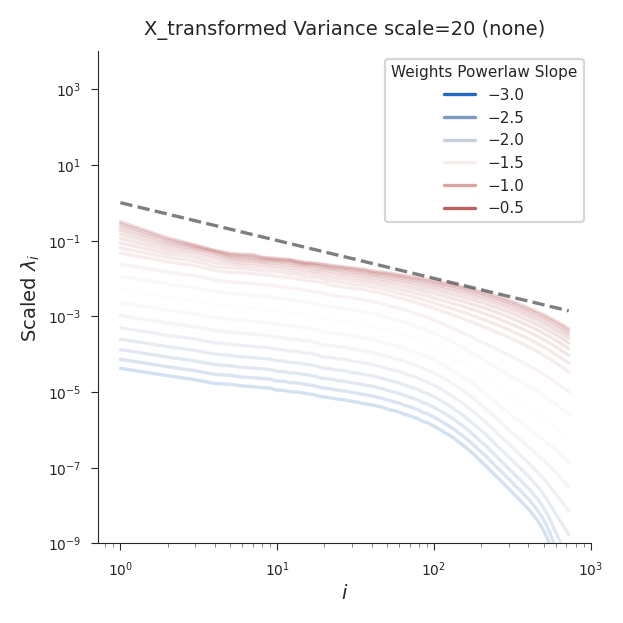

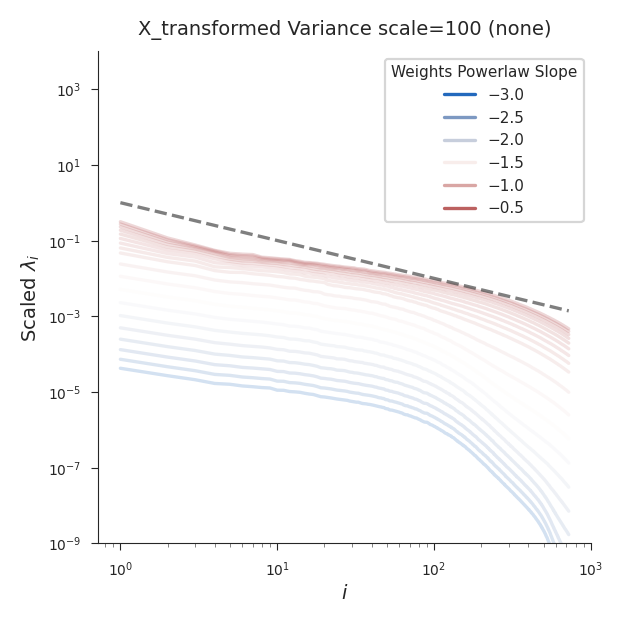

In [2]:
files = ['Eig-Vscale']
v_scales = [1, 2, 5, 10, 20, 100]
pooling = ['max', 'none']
dataset = 'majajhong2015'

spectra = True
encoding = False
rsa = False

for p in pooling:
    for v in v_scales:


#eigenspectra

        if spectra:
            
            f = files[0]
            t = f'X_transformed Variance scale={v} ({p})'
            
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            data = pd.merge(dm, ds, on=id_columns)
            data['id'] = data[id_columns].sum(axis='columns')
            data = data[ (data['layer']=='c2') ]
            data = data[ (data['source']==v) ]
            
        # Remove outlier low-variance points at the final PCs
            def is_outlier(i):
                i = np.log(i)
                cutoff = 0.95 * i.iloc[-1]
                return i > cutoff
            outlier = data.groupby(id_columns)['n'].transform(is_outlier)
            data = data[~outlier]

        # Set y-intercept to 1
            def get_scaled_var(x):
                i, y = x['n'].values, x['variance'].values
                i, y = np.log(i), np.log(y)
                intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                intercept = np.exp(intercept)
                return x['variance'] / intercept
            scaled_var = data.groupby(id_columns).apply(get_scaled_var)
            scaled_var = scaled_var.reset_index(id_columns, drop=True)
            data['scaled_variance'] = scaled_var

        # Log(ED)
            data['log_ed'] = np.log10(data['effective dimensionality'])

            fig, ax = plt.subplots(figsize=(3, 3))
            sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                        units='id', alpha=0.2, estimator=None,
                        palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
            ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
            ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
            ax.set_ylim(bottom=10**(-9), top=10**4)
            ax.legend(title='Weights Powerlaw Slope')
            #ax.legend(title=r'$\log{(ED)}$')
            #plt.show()
                
                
            #encoding score
            
        if encoding:
            f = files[0]
            regressions = ['pls', 'lin', 'ridge_alpha=1', 'ridge_alpha=10', 'ridge_alpha=100', 'ridge_alpha=1000']
            for reg in regressions:
                
                t = f'X_transformed Encoding ({reg}) Variance Scale={v}'
                
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                de = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
                data = pd.merge(de, dm, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['source']==v) ]
                data['id'] = data[id_columns].sum(axis='columns')

                predictors = ['effective dimensionality', 'alpha']
                for pred in predictors:
                    r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                    sns.regplot(data=data, x=pred, y='score', 
                                logx=True,
                                scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                                ax=ax)
                    ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                    ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                    #ax.set_ylim(bottom=0, top=0.65)
                    #ax.set_xlim(0.8, 270)
                
                
        
        if rsa:
            f = files[0]
            t = f'X_transformed RSA (Variance Scale={v})'
            for p2 in ['True', 'False']:
            
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                de = pd.read_csv(f'../../results_marcc/atlasnet/rsa_{f}|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:{p2}.csv')
                #dm['task'] = de['task']
                data = pd.merge(de, dm, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['source']==v) ]
                data['id'] = data[id_columns].sum(axis='columns')

                predictors = ['effective dimensionality', 'alpha']
                for pred in predictors:
                    r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                    sns.regplot(data=data, x=pred, y='score', 
                                logx=True,
                                scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                                ax=ax)
                    ax.set(xlabel=f'{pred} (pooling={p})', ylabel=rf'RDM $R^2$ (pooling={p2})', xscale='log', title=t)
                    ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                    #ax.set_ylim(bottom=0, top=0.65)
                    #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensional

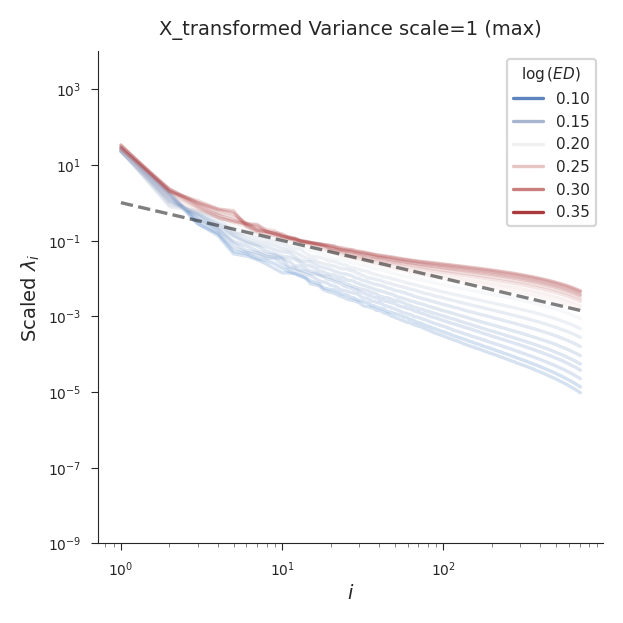

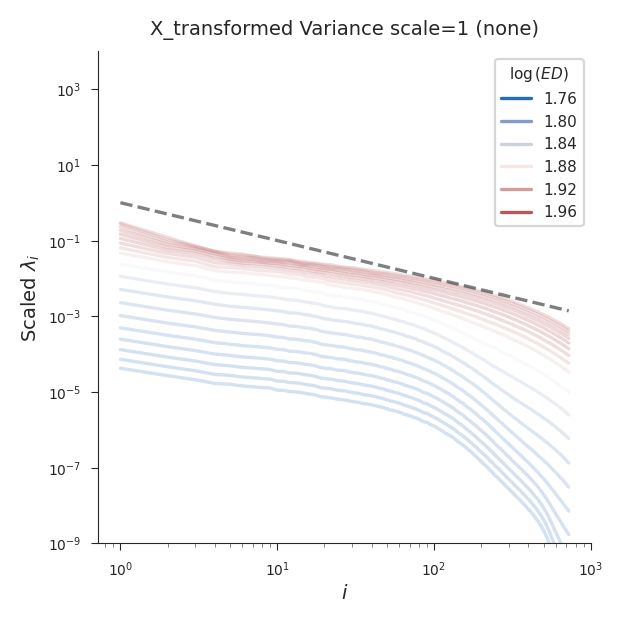

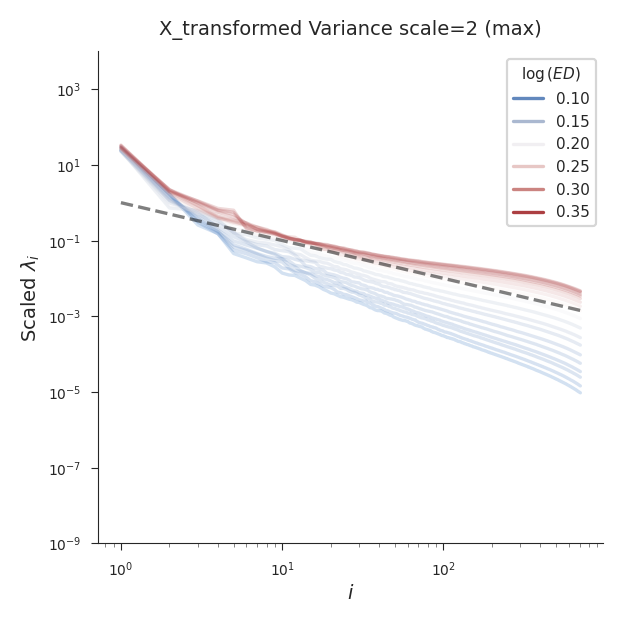

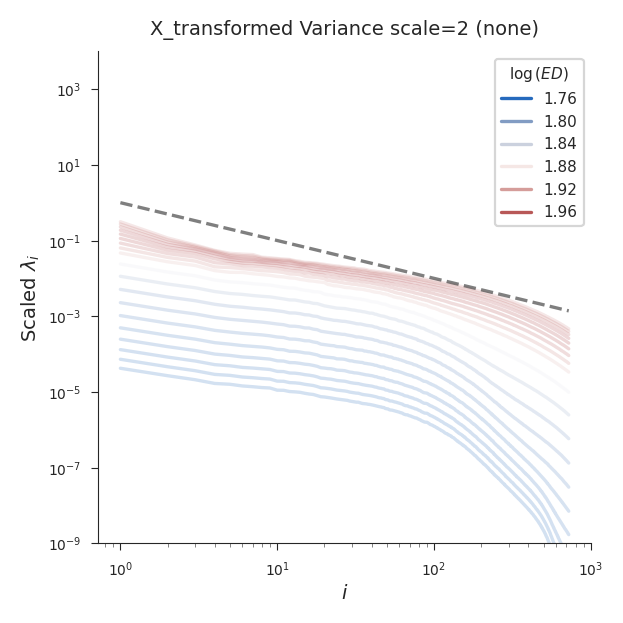

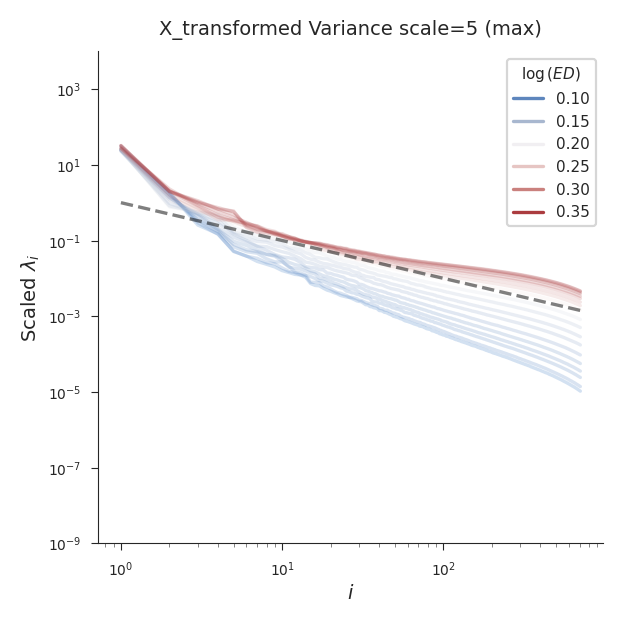

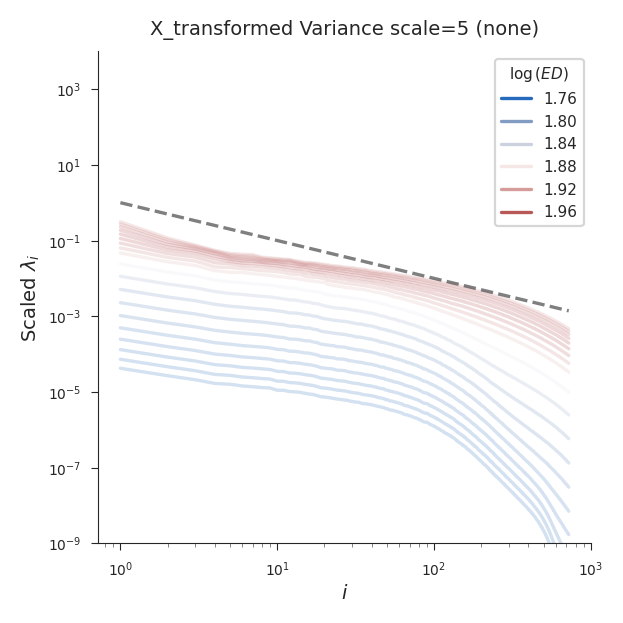

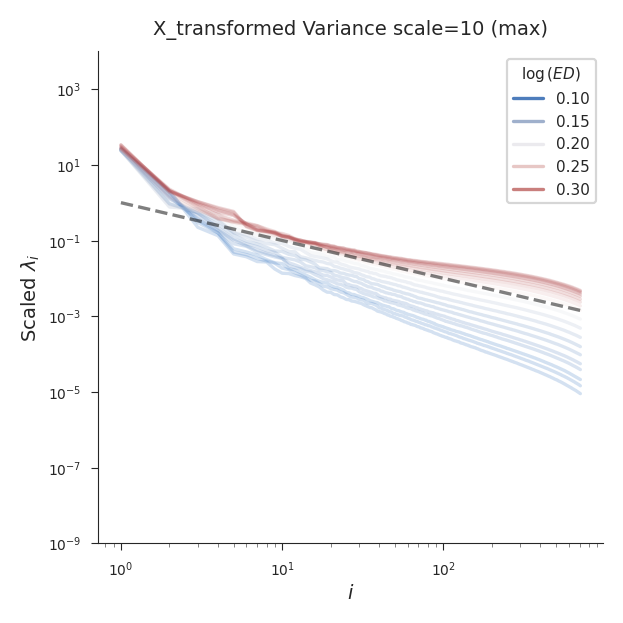

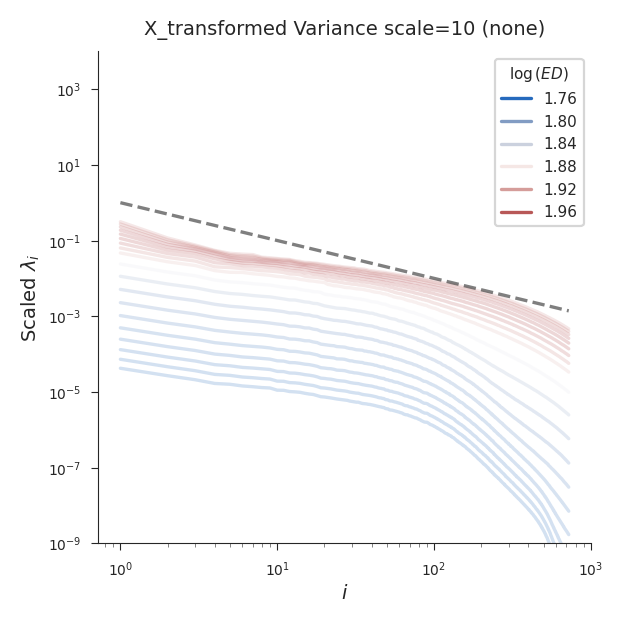

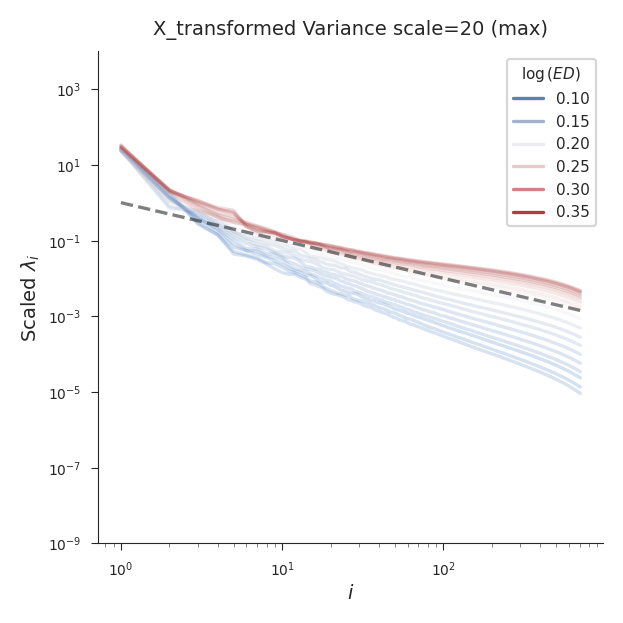

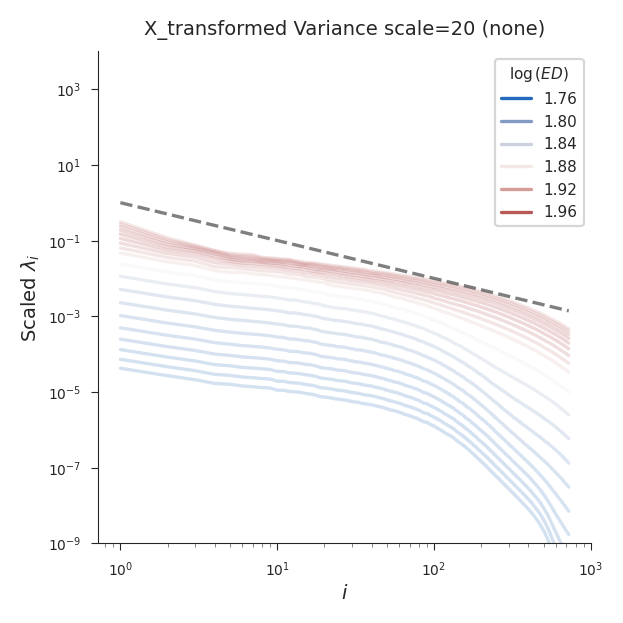

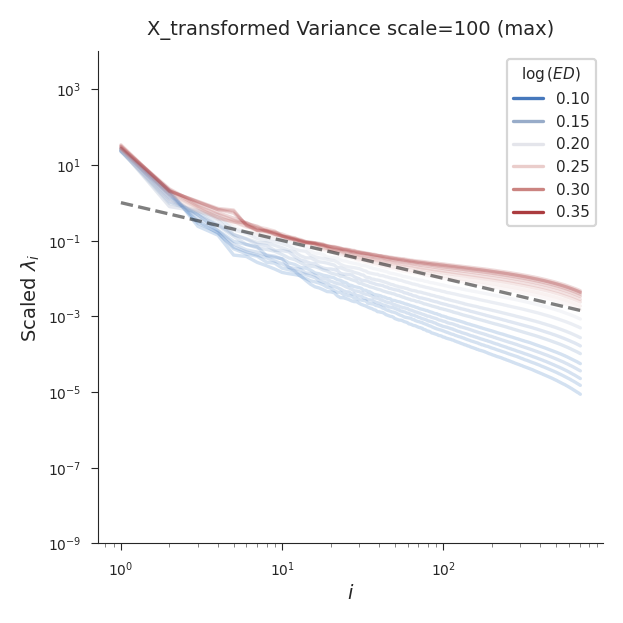

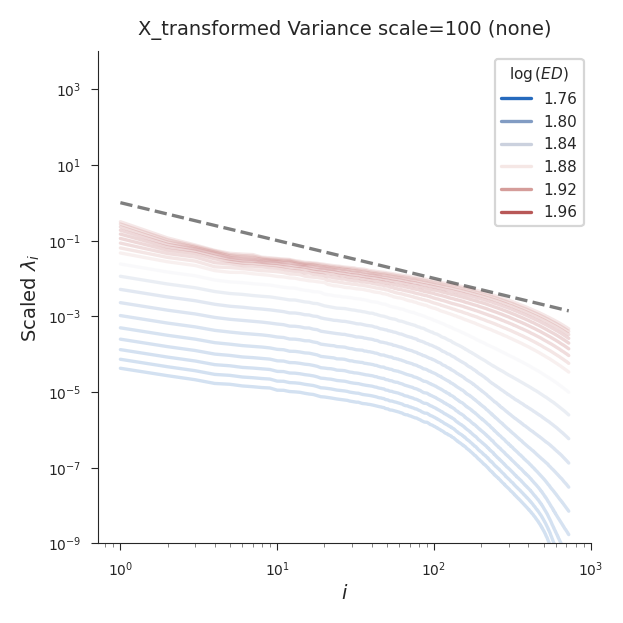

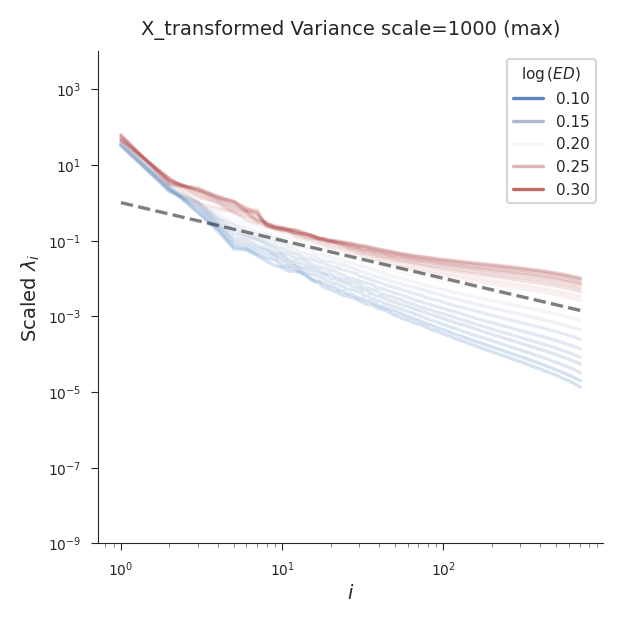

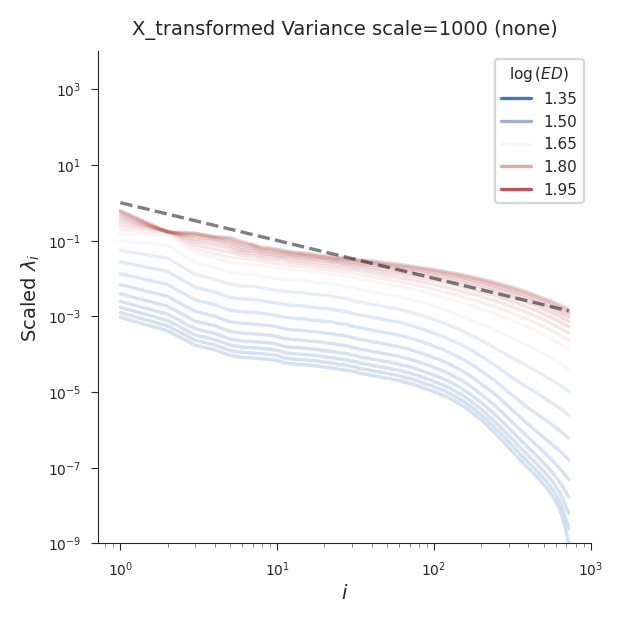

In [15]:
files = ['Eig-Vscale', 'Eig-Vscale1000']
v_scales = [1, 2, 5, 10, 20, 100]
pooling = ['max', 'none']

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

for f in files:
    if f == 'Eig-Vscale':
        dataset = 'majajhong2015'
        for v in v_scales:
            for p in pooling:
                
                t = f'X_transformed Variance scale={v} ({p})'
                
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                data = pd.merge(dm, ds, on=id_columns)
                data['id'] = data[id_columns].sum(axis='columns')
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['source']==v) ]
                
            # Remove outlier low-variance points at the final PCs
                def is_outlier(i):
                    i = np.log(i)
                    cutoff = 0.95 * i.iloc[-1]
                    return i > cutoff
                outlier = data.groupby(id_columns)['n'].transform(is_outlier)
                data = data[~outlier]

            # Set y-intercept to 1
                def get_scaled_var(x):
                    i, y = x['n'].values, x['variance'].values
                    i, y = np.log(i), np.log(y)
                    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                    intercept = np.exp(intercept)
                    return x['variance'] / intercept
                scaled_var = data.groupby(id_columns).apply(get_scaled_var)
                scaled_var = scaled_var.reset_index(id_columns, drop=True)
                data['scaled_variance'] = scaled_var

            # Log(ED)
                data['log_ed'] = np.log10(data['effective dimensionality'])

                fig, ax = plt.subplots(figsize=(3, 3))
                sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                            units='id', alpha=0.2, estimator=None,
                            palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
                ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
                ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
                ax.set_ylim(bottom=10**(-9), top=10**4)
                #ax.legend(title='Weights Powerlaw Slope')
                ax.legend(title=r'$\log{(ED)}$')
                #plt.show()


    elif f == 'Eig-Vscale1000':
        dataset = 'imagenet'
        for p in pooling:
        
            t = f'X_transformed Variance scale=1000 ({p})'
            
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            data = pd.merge(dm, ds, on=id_columns)
            data['id'] = data[id_columns].sum(axis='columns')
            data = data[ (data['layer']=='c2') ]
            
        # Remove outlier low-variance points at the final PCs
            def is_outlier(i):
                i = np.log(i)
                cutoff = 0.95 * i.iloc[-1]
                return i > cutoff
            outlier = data.groupby(id_columns)['n'].transform(is_outlier)
            data = data[~outlier]

        # Set y-intercept to 1
            def get_scaled_var(x):
                i, y = x['n'].values, x['variance'].values
                i, y = np.log(i), np.log(y)
                intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                intercept = np.exp(intercept)
                return x['variance'] / intercept
            scaled_var = data.groupby(id_columns).apply(get_scaled_var)
            scaled_var = scaled_var.reset_index(id_columns, drop=True)
            data['scaled_variance'] = scaled_var

        # Log(ED)
            data['log_ed'] = np.log10(data['effective dimensionality'])

            fig, ax = plt.subplots(figsize=(3, 3))
            sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                        units='id', alpha=0.2, estimator=None,
                        palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
            ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
            ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
            ax.set_ylim(bottom=10**(-9), top=10**4)
            #ax.legend(title='Weights Powerlaw Slope')
            ax.legend(title=r'$\log{(ED)}$')
            #plt.show()
        

plt.show()